# Введение

В тетрадке находится исследование данных и несколько решений.

Моё **финальное решение**, которое я пометил  было связано с выбором по квантилям и получило следующие результаты:

- **П: 0.5679038  146 / 551**
- **Ф: 0.5774261  76 / 551**


Вообще было много разных гипотез с отбрасыванием, фильтрацией юзеров, коррекцией координат, но все они не получили хороших результатов на паблике. Может быть где-то я ошибся, но есть то, что есть. 

Например, **"МинМин-МаксМакс фильтрацией Юзеров по sum_user_iou. Фильтр больше 7"**. На трейне: 7.0 0.5168047161509779, Остальные: 6.5 0.5202290654559895, 7.5 0.5126484449194525

Получил:

- *П: 0.5678838  151 / 551*
- *Ф: 0.5769281  177 / 551*


Даже та гипотеза, которая взяло награждаемое место была плохой. Возможно, как-нибудь проверю их и отправлю в песочницу.

**Некоторые Решения**:

- [baseline](#%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5---baseline)
- [Квантиль](#%D0%9A%D0%B2%D0%B0%D0%BD%D1%82%D0%B8%D0%BB%D1%8C,-%D0%BC%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D0%B0)  **<-- Награждаемое решение**
- [Предиктор для трёх координат](#%D0%9F%D1%80%D0%B5%D0%B4%D0%B8%D0%BA%D1%82%D0%BE%D1%80-%D0%B4%D0%BB%D1%8F-%D0%A2%D1%80%D1%91%D1%85-%D0%BA%D0%BE%D0%BE%D1%80%D0%B4%D0%B8%D0%BD%D0%B0%D1%82)

В этом списке решений я переставил решение с Квантилем сразу после МинМинМаксМакс (ММММ), чтобы было быстрее смотреть, но исторически оно было совершено только после всяких фильтраций ММММ и перед тем как применять предикторы с IoU по пользователям и др. признаками.


В разделе "Разное" есть некоторые заметки по поводу решения.

На разборе задач один парень сказал -- смотри, у нас смещение данных в зависимости от размера изображений. У меня была такая же гипотеза, но пришла она уже ближе к дедлайну.

**Разные заметки для себя на потом:**

- Multi-output в машинном обучении (не успел проверить)

https://habr.com/ru/post/358954/

https://stackoverflow.com/questions/43532811/gridsearch-over-multioutputregressor

- буст ММММ Xmin += (Xmax - Xmin) / 1000 (Михаил Дектярёв)
- Если Xmin > 70 then Xmin-= 22% от Xmin  (ML boot camp official)

# Иницализация

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import model_selection

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import make_scorer

In [2]:
#  Может быть поменять реализацию этой функции расчёта IOU ????
# https://medium.com/koderunners/intersection-over-union-516a3950269c

# def intersection_over_union_versiontwo(box1, box2):
#     x1, y1, w1, h1 = box1
#     x2, y2, w2, h2 = box2
def intersection_over_union_versiontwo(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

# iou = [IOU(y_test[i], y_pred[i]) for i in range(len(x_test))]

# xmin1, ymin1, xmax1, ymax1 = 47,650, 213,812
# xmin2, ymin2, xmax2, ymax2 = 62,656, 276,803
# xmin2, ymin2, xmax2, ymax2 = 47,650, 213,812

# xmin1, ymin1, xmax1, ymax1 = 45,1243, 45,1243
# xmin2, ymin2, xmax2, ymax2 = 45,1243, 45,1243


# print(intersection_over_union_versiontwo((xmin1, ymin1, xmax1-xmin1, ymax1-ymin1),(xmin2, ymin2, xmax2-xmin2, ymax2-ymin2)))

In [3]:
def perimetr(box):
    return (box[2] - box[0] + box[3] - box[1])
# data['area_true'] = data[['Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(perimetr, axis=1)



def diagonal_length2(box):
    return (box[2] - box[0])**2 + (box[3] - box[1])**2
# data['area_true'] = data[['Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(diagonal_length2, axis=1)



def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



def iou_areas(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    unionArea = float(boxAArea + boxBArea - interArea)
#     iou = interArea / unionArea
#     iou = interArea / float(boxAArea + boxBArea - interArea)
    return [interArea, unionArea]
#     return iou, interArea, unionArea



def predict_scorer(votes):
    quorum_min = votes.groupby("itemId")[['Xmin','Ymin']].min().reset_index()
    quorum_max = votes.groupby("itemId")[['Xmax', 'Ymax']].max().reset_index()
    res = quorum_min.merge(quorum_max, on=['itemId'])
    return res



def iou_scorer_fun(y_true, y_pred):
    #  y_true is pd.DataFrame
    #  y_pred is numpy.ndarray
    #     
    # Method to print messages in gridsearchcv.
#     try:
#         assert False, "Assert!"
#     except AssertionError as e:
#         e.args += ('y_true', y_true.shape, y_true.columns, y_true.head(), 'y_pred', y_pred.shape, y_pred)
#         raise

#  IOU по всей выборке 
#     y_pred = pd.DataFrame(y_pred, columns=['Xmin','Ymin', 'Xmax', 'Ymax'])
#     df = pd.concat([y_pred, y_true.reset_index()], axis=1)
#     df["iou"] = df[['Xmin','Ymin', 'Xmax', 'Ymax', \
#       'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
    
#     return df["iou"].mean()

    # по идеее метрика теста должна быть такой что мы смотрим занчения, сгруппированные только для itemId
    y_true['itemId'] = y_true.index
    y_pred = pd.DataFrame(y_pred, columns=['Xmin','Ymin', 'Xmax', 'Ymax'])
    
    df = pd.concat([y_pred, y_true.reset_index()], axis=1)  # Нужна только колонка 'itemId'
    
    df = predict_scorer(df)  # делаем ММММ
    df = pd.concat([y_pred, y_true.reset_index()], axis=1)  # ДОбавляем true X,Y

#     try:
#         assert False, "Assert!"
#     except AssertionError as e:
#         e.args += ('y_true', y_true.shape, y_true.columns, y_true.head(), 
#                    'y_pred', y_pred.shape, y_pred.columns, y_pred.head(),
#                    'df', df.shape, df.columns, df.head())
#         raise 
    
    df["iou"] = df[['Xmin','Ymin', 'Xmax', 'Ymax', \
      'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
 
    return df["iou"].mean()

iou_scorer = make_scorer(iou_scorer_fun, greater_is_better=True)

In [4]:
# Проверка IOU

# xmin1, ymin1, xmax1, ymax1 = 3,3, 4,4
# xmin2, ymin2, xmax2, ymax2 = 0,0, 4,4

xmin1, ymin1, xmax1, ymax1 = 47,650, 213,812
# xmin2, ymin2, xmax2, ymax2 = 62,656, 276,803
xmin2, ymin2, xmax2, ymax2 = 47,650, 213,812

boxes = pd.Series([xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2]);
print(intersection_over_union(boxes))

# boxes = pd.Series([xmin2, ymin2, xmax2, ymax2, xmin1, ymin1, xmax1, ymax1]);
# print(intersection_over_union(boxes))

1.0


In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# digits = load_digits()
# X, y = digits.data, digits.target


# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

# plt.show()

#  Данные

In [6]:
def init_data():
    data = votes.merge(answers, on=["itemId"])
    return data

def init_test_data():
    data = test_votes.copy()
    return data


# IOU 
def data_add_iou(data):
    data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', \
          'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
    
    return data


# Площадь выделения
def data_add_area(data):
    data['area'] = data[['Xmin','Ymin', 'Xmax', 'Ymax']].apply(area, axis=1)
    if 'Ymax_true' in data.columns:
        data['area_true'] = data[['Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(area, axis=1)
    
    return data


# Периметр выделения и диагональ
def data_add_perimetr(data):
    data['perimetr'] = data[['Xmin','Ymin', 'Xmax', 'Ymax']].apply(perimetr, axis=1)
    data['diaglength2'] = data[['Xmin','Ymin', 'Xmax', 'Ymax']].apply(diagonal_length2, axis=1)
    if 'Ymax_true' in data.columns:
        data['perimetr_true'] = data[['Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(perimetr, axis=1)
        data['diaglength2_true'] = data[['Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(diagonal_length2, axis=1)
    
    return data



#  Точность юзера
def data_add_userIoU(data):
    
    data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', \
          'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
    
    mean_user_iou = data.groupby("userId")['iou'].mean()
    mean_user_iou = pd.DataFrame(mean_user_iou);  mean_user_iou.columns = ['mean_user_iou']
    data = data.merge(right=mean_user_iou, how='inner', left_on='userId', right_index=True)

    median_user_iou = data.groupby("userId")['iou'].median()
    median_user_iou = pd.DataFrame(median_user_iou);  median_user_iou.columns = ['median_user_iou']
    data = data.merge(right=median_user_iou, how='inner', left_on='userId', right_index=True)

    sum_user_iou = data.groupby("userId")['iou'].sum()
    sum_user_iou = pd.DataFrame(sum_user_iou);  sum_user_iou.columns = ['sum_user_iou']
    data = data.merge(right=sum_user_iou, how='inner', left_on='userId', right_index=True)
    
    data.drop('iou', axis=1, inplace=True)
    
    return data



# Ошибки на картинках
def data_add_xy_err(data):
    data['Xmin_err'] = (data['Xmin_true'] - data['Xmin'])
    data['Ymin_err'] = (data['Ymin_true'] - data['Ymin'])
    data['Xmax_err'] = (data['Xmax_true'] - data['Xmax'])
    data['Ymax_err'] = (data['Ymax_true'] - data['Ymax'])
    
    return data



# Значение Медианной ошибки
def data_add_median_err(data):
    Xmin_med_err = data.groupby('itemId')['Xmin_err'].median()
    Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
    data = data.merge(right=Xmin_med_err, how='inner', left_on='itemId', right_index=True)
    del Xmin_med_err

    Ymin_med_err = data.groupby('itemId')['Ymin_err'].median()
    Ymin_med_err = pd.DataFrame(Ymin_med_err);  Ymin_med_err.columns = ['Ymin_med_err']
    data = data.merge(right=Ymin_med_err, how='inner', left_on='itemId', right_index=True)
    del Ymin_med_err

    Xmax_med_err = data.groupby('itemId')['Xmax_err'].median()
    Xmax_med_err = pd.DataFrame(Xmax_med_err);  Xmax_med_err.columns = ['Xmax_med_err']
    data = data.merge(right=Xmax_med_err, how='inner', left_on='itemId', right_index=True)
    del Xmax_med_err

    Ymax_med_err = data.groupby('itemId')['Ymax_err'].median()
    Ymax_med_err = pd.DataFrame(Ymax_med_err);  Ymax_med_err.columns = ['Ymax_med_err']
    data = data.merge(right=Ymax_med_err, how='inner', left_on='itemId', right_index=True)
    del Ymax_med_err
    
    return data



def data_add_iou_intsc_un(res):
    dataM = res.merge(answers, on=["itemId"])
    dataM["temp"] = dataM[['Xmin','Ymin', 'Xmax', 'Ymax', \
          'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(iou_areas, axis=1)

    dataM.drop([656, 805], inplace=True)   # потому что там площадь выделения равно 0, а такого быть не может, похоже на выброс

    L = []
    for index, row in dataM.iterrows():
        mylist = list((row['temp'][0], row['temp'][1], row['temp'][2]))
        L.append(mylist)

    df2 = pd.DataFrame(L, index=dataM.index, columns=['iou','intesect', 'union'])
    dataM = dataM.merge(right=df2, left_index=True, right_index=True, how='left')
#     dataM.drop("temp", inplace=True)
    
    return dataM





In [7]:
def draw_box(tmp_usr, tmp_item=-1):
    if tmp_item == -1:
        tmp = data[data['userId'] == tmp_usr]
    else:
        tmp = data[(data['userId'] == tmp_usr) & (data['itemId'] == tmp_item)]

    plt.figure()
    fig,ax = plt.subplots(1)

    for x_min, y_min, x_max, y_max in zip(tmp['Xmin'],tmp['Ymin'],tmp['Xmax'],tmp['Ymax']):
        rect = patches.Rectangle((x_min, y_min),x_max-x_min, y_max-y_min,
                                 linewidth=1, edgecolor='r',facecolor='none', alpha=.3)
        ax.add_patch(rect)

        plt.plot(x_min, y_min, '*')
        plt.plot(x_min, y_max, '*')
        plt.plot(x_max, y_min, '*')
        plt.plot(x_max, y_max, '*')

    # plt.axis((0,max(tmp['Xmax']+5),0,max(tmp['Ymax']+5)))
    # plt.axis('square')
    plt.axis('equal')

    plt.show()

In [8]:
#  Удаляем юзеров, у которых mean_user_iou < iou_thr. 
# При этом оставляем картинки, у которых других оценок кроме этого пользователя нет.
# 
def remove_users_by_miou(data, col, iou_thr):
    for it in data['itemId'].unique():
        tmp = data[data['itemId'] == it]
        if tmp.shape[0] > 1:
            selected = data[ (data['itemId'] == it) & (data[col] < iou_thr) ]['userId'].values
            selected = data[data['userId'].isin(selected)].index
            data.drop(selected, inplace=True)
    return data



def data_drop_nullarea(data):
    # коррекция
#     ind = data[data['area'] == 6].index
#     data.loc[ind, 'Xmin'] -= 1
#     data.loc[ind, 'Ymin'] -= 1
#     data.loc[ind, 'Xmax'] += 1
#     data.loc[ind, 'Ymax'] += 1

#     data.drop(data[data['area'] < 6 ].index, inplace=True)  в этом случае в тесте есть меньшая площадь. А там один юзер
    data.drop(data[data['area'] == 0 ].index, inplace=True)
    
    return data



def data_drop_nullareatrue(data):
    data.drop(data[data['area_true'] == 0].index, inplace=True)
    return data




#  проверяем, все ли картинки остались после фильтрации. 
# Их порядок не важен, в Сабмите они сортируются по возрастанию
def test_structure(test_data):
    print('Весь DataFrame: Должны быть равны')
    print(test_data.shape, ' / ', test_votes.shape)
    
    print('unique: Должны быть равны')
    print(test_data['itemId'].unique().shape, ' / ', test_votes['itemId'].unique().shape)
        
    i=0    
    for it in sorted(test_votes['itemId'].unique()):
        if not it in sorted(test_data['itemId'].unique()):
            print(i, it)
            i=i+1
    if i==0:
        print('All good')
    else:
        print('#num', 'itemId')

# def test_structure(test_data):
#     # проверяем структуру ВСЕГО СЕТА, что картинки и ПОЛЬЗОВАТЕЛИ идут в нужном порядке
#     for i in range(test_votes['itemId'].shape[0]):
#         if not test_votes['itemId'][i] == test_data['itemId'][i]:
#             print(i, test_data['itemId'])


In [9]:
def predictByMinMax(votes):
    quorum_min = votes.groupby("itemId")[['Xmin','Ymin']].min().reset_index()
    quorum_max = votes.groupby("itemId")[['Xmax', 'Ymax']].max().reset_index()
    res = quorum_min.merge(quorum_max, on=['itemId'])
    return res



# def local_miou_score(data_filt, res):
def local_miou_score(res):
    data_filt = res.merge(answers, on=["itemId"])
    data_filt["iou"] = data_filt[['Xmin','Ymin', 'Xmax', 'Ymax', \
          'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

    return data_filt["iou"].mean()

In [10]:
votes = pd.read_csv("data/train_data.csv")
answers = pd.read_csv("data/train_answers.csv")

test_votes = pd.read_csv("data/test_data.csv")

## смотрим данные

In [11]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

In [138]:
data.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   

   Ymax_true       iou   area  area_true  
0        812  0.613974  31458      26892  
1        812  0.079069   3978      26892  
2        812  0.598080  38038      26892  
3        812  0.435805  27548      26892  
4        812  0.750206  30576      26892

In [7]:
test_votes.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax
0    1581   34804    86   640   242   743
1    1351   34804    85   655   273   766
2     161   34804    85   648   268   748
3     313    5704    32   618   647  1268
4    1097    5704    25   620   602  1242

### Распределение точек

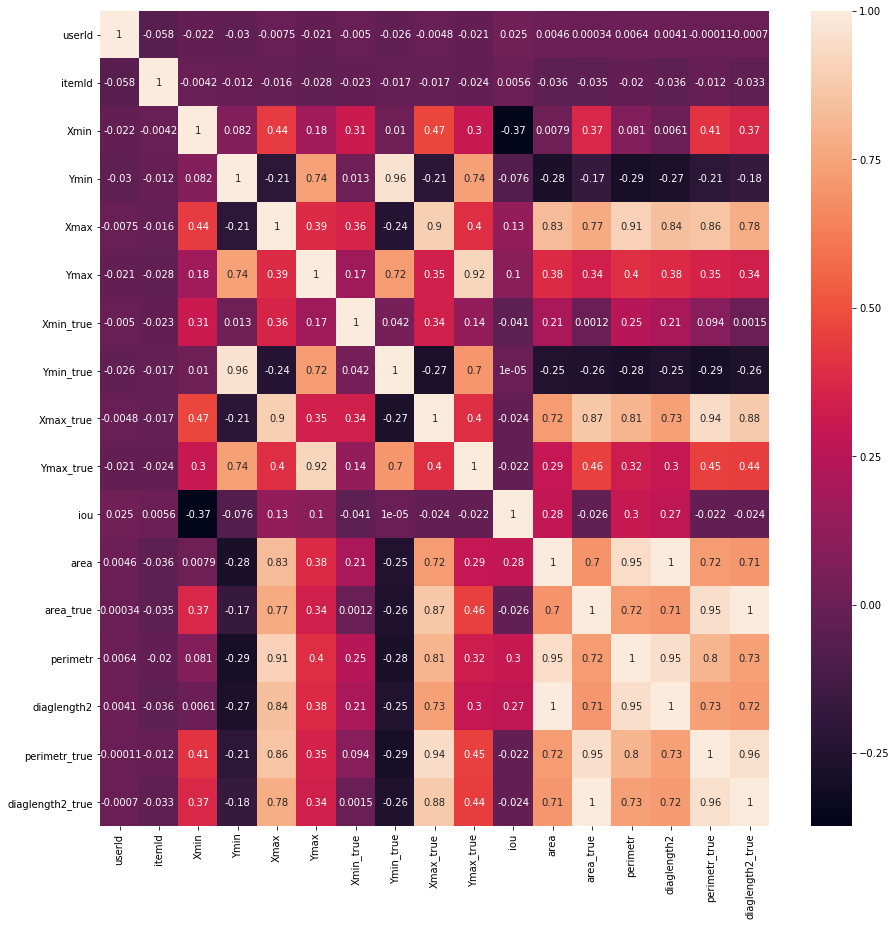

In [44]:
cols = data.columns

plt.figure(figsize=(15,15))

sns.heatmap(data[cols].corr('pearson'), annot= True)

<Figure size 1080x1080 with 0 Axes>

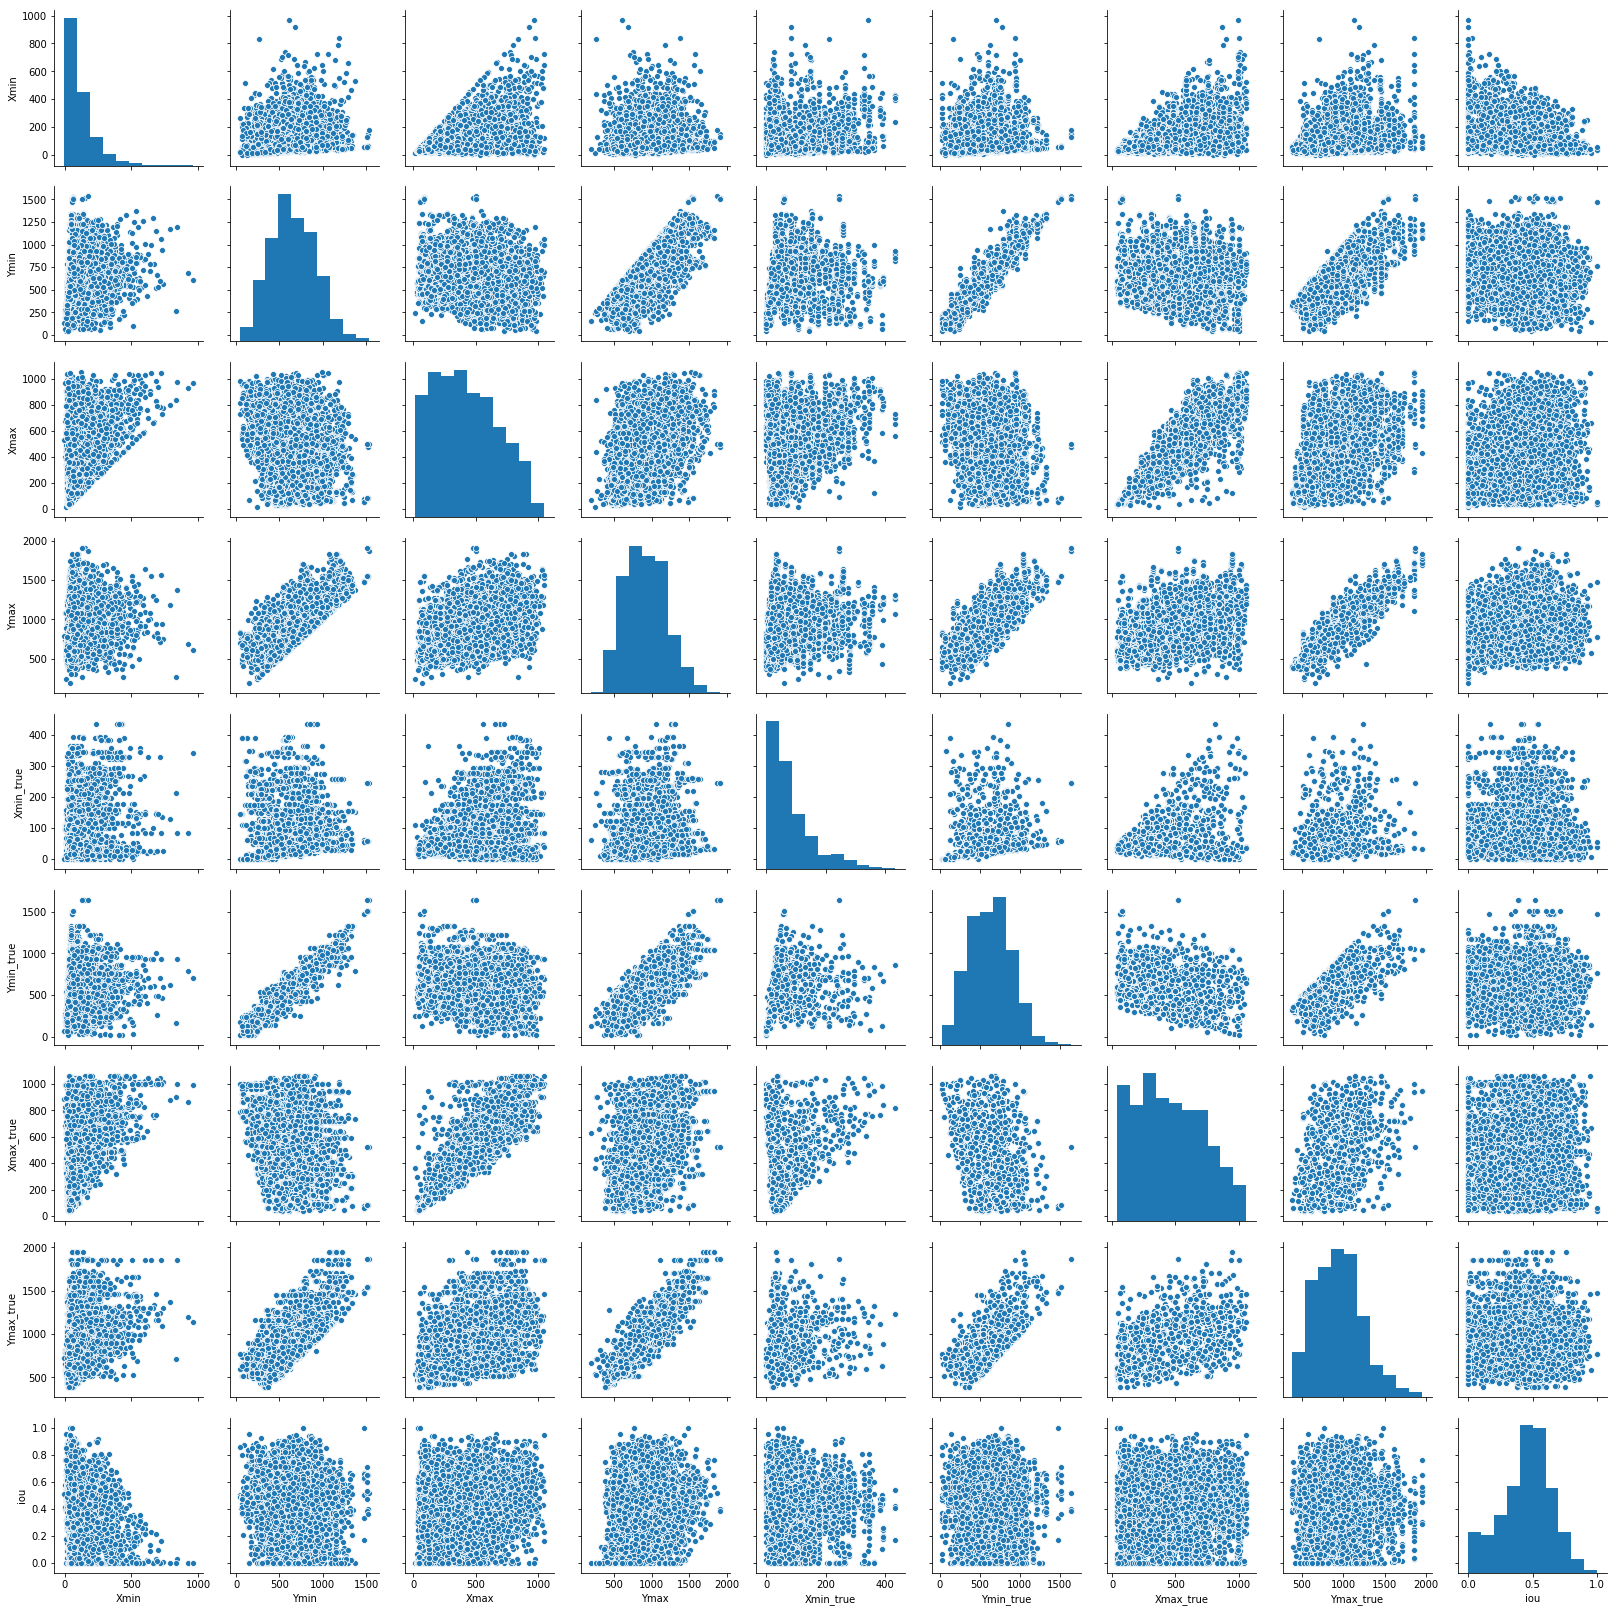

In [509]:
cols = ['Xmin','Ymin','Xmax','Ymax','Xmin_true','Ymin_true','Xmax_true','Ymax_true', 'iou']

plt.figure(figsize=(15,15))
sns.pairplot(data[cols])
del cols

/home/ivan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


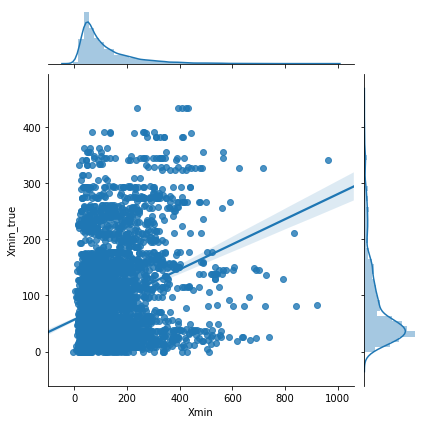

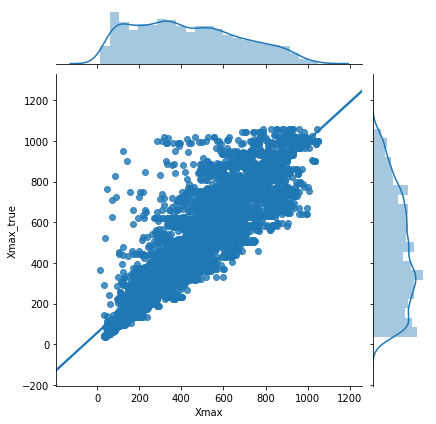

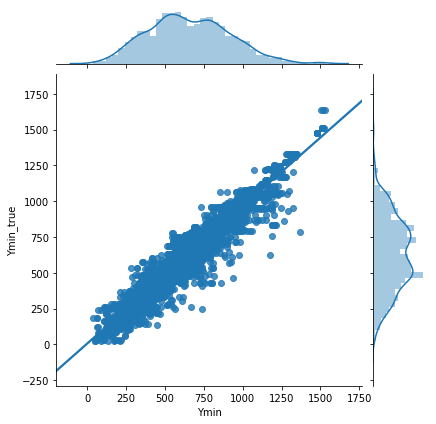

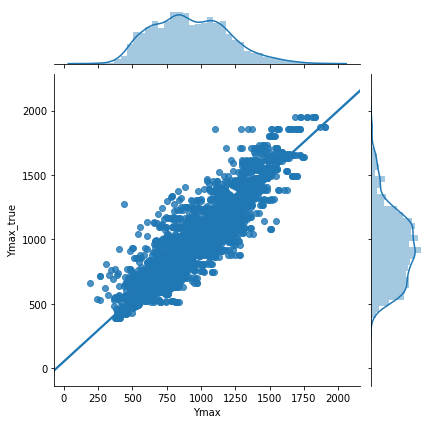

In [8]:
# plt.figure(figsize=(10,7))
# plt.subplot(221)
# plt.plot(data['Xmin'], data['Xmin_true'], '.')
# plt.xlabel('Xmin'), plt.ylabel('True')
# plt.subplot(222)
# plt.plot(data['Ymin'], data['Ymin_true'], '.')
# plt.xlabel('Ymin'), plt.ylabel('True')
# plt.subplot(223)
# plt.plot(data['Xmax'], data['Xmax_true'], '.')
# plt.xlabel('Xmax'), plt.ylabel('True')
# plt.subplot(224)
# plt.plot(data['Ymax'], data['Ymax_true'], '.')
# plt.xlabel('Ymax'), plt.ylabel('True')

sns.jointplot("Xmin", "Xmin_true", data=data, kind="reg")
sns.jointplot("Xmax", "Xmax_true", data=data, kind="reg")
sns.jointplot("Ymin", "Ymin_true", data=data, kind="reg")
sns.jointplot("Ymax", "Ymax_true", data=data, kind="reg")

In [12]:
# Есть ли ошибочные данные?
print(data[data['Xmax'] < data['Xmin']].count())
print(data[data['Ymax'] < data['Ymin']].count())

userId       0
itemId       0
Xmin         0
Ymin         0
Xmax         0
Ymax         0
Xmin_true    0
Ymin_true    0
Xmax_true    0
Ymax_true    0
iou          0
area         0
area_true    0
dtype: int64
userId       0
itemId       0
Xmin         0
Ymin         0
Xmax         0
Ymax         0
Xmin_true    0
Ymin_true    0
Xmax_true    0
Ymax_true    0
iou          0
area         0
area_true    0
dtype: int64


In [13]:
data[(data['Xmin'] <= 0) | (data['Xmax'] <= 0) | (data['Ymin'] <= 0) | (data['Ymax'] <= 0)] 

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
3176    1261   17194    -4   131   533   784          0         64        887   

      Ymax_true       iou    area  area_true  
3176        724  0.509779  350661     585420

### Площадь

In [43]:
plt.figure()
plt.plot(sorted(data.area), '.', label='area')
plt.plot(sorted(data.area_true), '.', label='area_true')
plt.ylabel('area'), plt.legend()

print(sorted(data.area)[:20])
print(sorted(data.area_true)[:20])

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 32, 32, 32, 36, 36, 36, 36, 36, 36, 36, 36]


In [144]:
data[data['area_true'] < 7]

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
3541     242   25142    54  1476    57  1478         55       1475         57   
3542     941   25142    55  1476    57  1478         55       1475         57   
3543    1123   25142    54  1476    57  1478         55       1475         57   
3544     291   25142    56  1476    57  1477         55       1475         57   
3545      77   25142    55  1475    57  1478         55       1475         57   
3546    1554   25142    54  1475    58  1478         55       1475         57   
3547      12   25142    54  1476    57  1478         55       1475         57   
3548     952   25142    55  1476    57  1477         55       1475         57   
3549     189   25142    54  1475    57  1478         55       1475         57   
4164     941   25135    45  1243    45  1243         45       1243         45   
4165    1539   25135    45  1243    45  1243         45       1243         45   
4166    1123   25135    45  1243    45  1243         45       1243         45   
4167     639   25135    45  1243    45  1243         45       1243         45   
4168     957   25135    45  1243    45  1243         45       1243         45   
4169     952   25135    45  1243    45  1243         45       1243         45   
4865     217   22483    37   768    40   770         37        768         40   
4866     110   22483    37   768    40   770         37        768         40   
4867    1595   22483    38   768    39   769         37        768         40   
4868    1470   22483    37   768    38   769         37        768         40   
4869    1408   22483    37   768    40   770         37        768         40   
4870    1222   22483    38   768    39   769         37        768         40   
5200     909   31033    47   963    48   963         47        963         48   
5201     859   31033    47   963    48   963         47        963         48   
5202    1671   31033    47   963    48   963         47        963         48   

      Ymax_true       iou  area  area_true  
3541       1478  0.500000     6          6  
3542       1478  0.666667     4          6  
3543       1478  0.500000     6          6  
3544       1478  0.166667     1          6  
3545       1478  1.000000     6          6  
3546       1478  0.500000    12          6  
3547       1478  0.500000     6          6  
3548       1478  0.333333     2          6  
3549       1478  0.666667     9          6  
4164       1243  0.000000     0          0  
4165       1243  0.000000     0          0  
4166       1243  0.000000     0          0  
4167       1243  0.000000     0          0  
4168       1243  0.000000     0          0  
4169       1243  0.000000     0          0  
4865        770  1.000000     6          6  
4866        770  1.000000     6          6  
4867        770  0.166667     1          6  
4868        770  0.166667     1          6  
4869        770  1.000000     6          6  
4870        770  0.166667     1          6  
5200        963  0.000000     0          0  
5201        963  0.000000     0          0  
5202        963  0.000000     0          0

**Заключение**: если меньше 6, то:
~~надо корректировать~~, 
если РАВНО *нулю*, то удалять.

Проверить: а может не меньше 6, а только равно 0?

#### Проверяем эту гипотезу

In [150]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

res = predictByMinMax(data)
local_miou_score(res)

0.5809800227327839

In [165]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

res = predictByMinMax(data)
local_miou_score(res)

0.5821831420884929

**Качество улучшилось.**

In [155]:
data[data['area_true'] < 7]

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
3541     242   25142    53  1475    58  1479         55       1475         57   
3543    1123   25142    53  1475    58  1479         55       1475         57   
3545      77   25142    54  1474    58  1479         55       1475         57   
3546    1554   25142    54  1475    58  1478         55       1475         57   
3547      12   25142    53  1475    58  1479         55       1475         57   
3549     189   25142    54  1475    57  1478         55       1475         57   
4865     217   22483    36   767    41   771         37        768         40   
4866     110   22483    36   767    41   771         37        768         40   
4869    1408   22483    36   767    41   771         37        768         40   

      Ymax_true       iou  area  area_true  
3541       1478  0.300000    20          6  
3543       1478  0.300000    20          6  
3545       1478  0.300000    20          6  
3546       1478  0.500000    12          6  
3547       1478  0.300000    20          6  
3549       1478  0.666667     9          6  
4865        770  0.300000    20          6  
4866        770  0.300000    20          6  
4869        770  0.300000    20          6

In [171]:
data.isnull().values.any()

False

In [42]:
print(sorted(data.area_true)[-20:])

[842724, 842724, 842724, 842724, 842724, 842724, 842724, 842724, 842724, 842724, 972840, 972840, 972840, 972840, 972840, 972840, 972840, 977130, 977130, 977130]


### Периметр и диагональ

In [45]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

data = data_add_perimetr(data)

# data.isnull().values.any()

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 18, 18, 18, 18, 18]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]


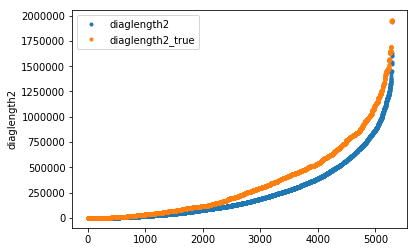

In [45]:
plt.figure()
plt.plot(sorted(data.perimetr), '.', label='perimetr')
plt.plot(sorted(data.perimetr_true), '.', label='perimetr_true')
plt.ylabel('perimetr'), plt.legend()

print(sorted(data.perimetr)[:20])
print(sorted(data.perimetr_true)[:20])

plt.figure()
plt.plot(sorted(data.diaglength2), '.', label='diaglength2')
plt.plot(sorted(data.diaglength2_true), '.', label='diaglength2_true')
plt.ylabel('diaglength2'), plt.legend()

print(sorted(data.diaglength2)[:20])
print(sorted(data.diaglength2_true)[:20])

In [ ]:
квантильная площадь и диагональ на картинку. кто меньше - не учитывать

### IOU

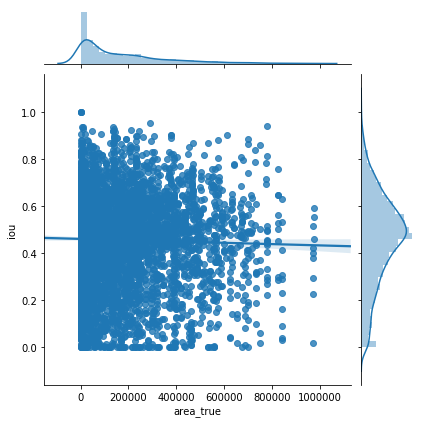

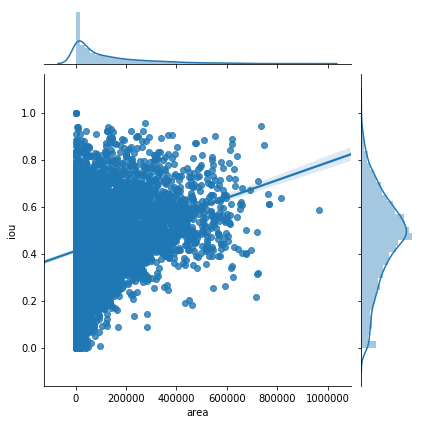

In [173]:
sns.jointplot("area_true", "iou", data=data, kind="reg")
sns.jointplot("area", "iou", data=data, kind="reg")

###  Отклонения точек от правильного ответа

In [46]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)
data = data_add_perimetr(data)

res = predictByMinMax(data)
local_miou_score(res)

0.5822325332074827

In [55]:
data = data_add_xy_err(data)

# data['Xmin_err'] = abs(data['Xmin_true'] - data['Xmin'])
# data['Ymin_err'] = abs(data['Ymin_true'] - data['Ymin'])
# data['Xmax_err'] = abs(data['Xmax_true'] - data['Xmax'])
# data['Ymax_err'] = abs(data['Ymax_true'] - data['Ymax'])

data.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   

   Ymax_true       iou   area  area_true  Xmin_err  Ymin_err  Xmax_err  \
0        812  0.613974  31458      26892       -15        -6       -63   
1        812  0.079069   3978      26892      -137       -12       -22   
2        812  0.598080  38038      26892       -16         2       -59   
3        812  0.435805  27548      26892       -64        13       -40   
4        812  0.750206  30576      26892       -13        -1       -29   

   Ymax_err  
0         9  
1        72  
2       -18  
3       -19  
4        -7

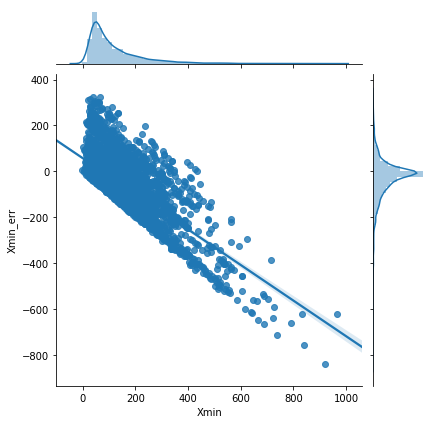

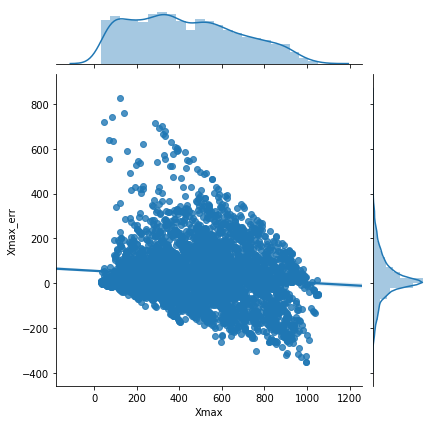

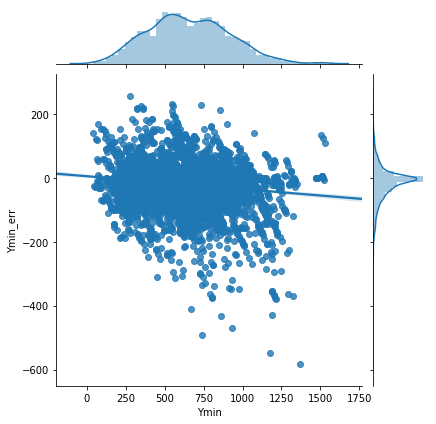

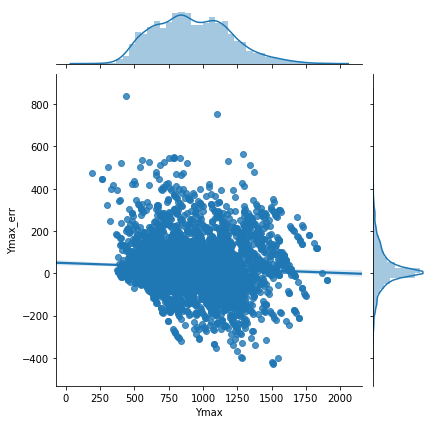

In [51]:
sns.jointplot("Xmin", "Xmin_err", data=data, kind="reg")
sns.jointplot("Xmax", "Xmax_err", data=data, kind="reg")
sns.jointplot("Ymin", "Ymin_err", data=data, kind="reg")
sns.jointplot("Ymax", "Ymax_err", data=data, kind="reg")

Видим, что для некоторых значений X и Y ошибка сосредоточена в ккаой-то области, а значит можно пробовать её корректировать. Например по среднему значению для этого интервала значений X и Y.

In [53]:
Xmin_med_err = data.groupby('Xmin')['Xmin_err'].median()
Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
data.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
147      592   24752    62  1077   672  1551         34       1054        712   
173      577   27107    62   594   549   864        215        496        565   
216      285   33084    62   662   382   877         67        647        428   
1033     872   32310    62   536   177   614         63        520        183   

      Ymax_true       iou    area  area_true  Xmin_err  Ymin_err  Xmax_err  \
0           812  0.613974   31458      26892       -15        -6       -63   
147        1709  0.651084  289140     444090       -28       -23        40   
173         939  0.459259  131490     155050       153       -98        16   
216         944  0.625392   68800     107217         5       -15        46   
1033        592  0.568680    8970       8640         1       -16         6   

      Ymax_err  Xmin_med_err  
0            9          -6.0  
147        158          -6.0  
173         75          -6.0  
216         67          -6.0  
1033       -22          -6.0

#### Гипотеза квантиильной коррекции по кординатам

In [79]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

data = data_add_xy_err(data)

# если применять ко всем картинам
# Xmin_med_err = data.groupby('Xmin')['Xmin_err'].median()  # 0.5851830601718125
Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(.58)  # 0.5870518398313752
Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
data.Xmin += data.Xmin_med_err


#  если применять только к картинкам не больше какого-то размера -- лучше пока не становится
# Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(.58)  # 0.5870518398313752
# Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
# data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
# data[data.Xmin < 400].Xmin += data[data.Xmin < 400].Xmin_med_err

res = predictByMinMax(data)
print(local_miou_score(res))

sns.jointplot("Xmin", "Xmin_err", data=data, kind="reg")

0.5870518398313752


Гипотеза улучшает качество.
**НО**, Я думаю, что надо при объединении делать не просто объединение, а смотреть на диапазон и изменения делать соответствующие диапазону. А сейчас получается объединение идёт по точному совпадению

#### Применяем ко всем остальным координатам

In [124]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

data = data_add_xy_err(data)

data.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   

   Ymax_true       iou   area  area_true  Xmin_err  Ymin_err  Xmax_err  \
0        812  0.613974  31458      26892       -15        -6       -63   
1        812  0.079069   3978      26892      -137       -12       -22   
2        812  0.598080  38038      26892       -16         2       -59   
3        812  0.435805  27548      26892       -64        13       -40   
4        812  0.750206  30576      26892       -13        -1       -29   

   Ymax_err  
0         9  
1        72  
2       -18  
3       -19  
4        -7

In [125]:
def find_XYerr_median_correction(data, thr):
# Ищем порог квантиля для каждой координаты.
# Найденное ставил вручную.
#     Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(thr)

#     Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(thr)
    Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(.58)  # 0.5870518398313752
    Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
    data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
    data.Xmin += data.Xmin_med_err
    '''
    0.0 0.5245297049932834
    0.11 0.5474244634902515
    0.22 0.5623838810703085
    0.33 0.5735788029991427
    0.44 0.581440913505223
    0.55 0.5866231344035884
    0.66 0.5806952098398246
    0.77 0.559759173691278
    0.88 0.5047761716783338
    0.99 0.40564083227442765
    '''


#     # начальное 0.5870518398313752
#     Ymin_med_err = data.groupby('Ymin')['Ymin_err'].quantile(thr)
    Ymin_med_err = data.groupby('Ymin')['Ymin_err'].quantile(0.7294736842105263)
#     Ymin_med_err = data.groupby('Ymin')['Ymin_err'].quantile(.85)
    Ymin_med_err = pd.DataFrame(Ymin_med_err);  Ymin_med_err.columns = ['Ymin_med_err']
    data = data.merge(right=Ymin_med_err, how='inner', left_on='Ymin', right_index=True)
    data.Ymin += data.Ymin_med_err
    '''
    0.4168421052631579 0.5469368030915386
    0.46894736842105267 0.5573482441833052
    0.5210526315789474 0.5677785160115751
    0.5731578947368421 0.5764853700437781
    0.6252631578947369 0.5835236992573357
    0.6773684210526316 0.5887700460884635
    0.7294736842105263 0.5922190176313118
    0.781578947368421 0.5914474352775141
    0.8336842105263158 0.5909004497179565
    0.8857894736842106 0.5882060983540294
    '''    
    
#     # начальное 0.5922190176313118
#     Xmax_med_err = data.groupby('Xmax')['Xmax_err'].quantile(thr)
    Xmax_med_err = data.groupby('Xmax')['Xmax_err'].quantile(0)
    Xmax_med_err = pd.DataFrame(Xmax_med_err);  Xmax_med_err.columns = ['Xmax_med_err']
    data = data.merge(right=Xmax_med_err, how='inner', left_on='Xmax', right_index=True)
    data.Xmax += data.Xmax_med_err
    '''
    0.0 0.6124296573915557
    0.05210526315789474 0.6082589439662923
    0.10421052631578948 0.6079086098149842
    0.1563157894736842 0.608086896790121
    0.20842105263157895 0.6074622406033059
    0.2605263157894737 0.6056117565059249
    0.3126315789473684 0.6020975151891826
    0.36473684210526314 0.5977187975398899
    '''
    
#     Ymax_med_err = data.groupby('Ymax')['Ymax_err'].quantile(thr)
    Ymax_med_err = data.groupby('Ymax')['Ymax_err'].quantile(.3126315789473684)
    Ymax_med_err = pd.DataFrame(Ymax_med_err);  Ymax_med_err.columns = ['Ymax_med_err']
    data = data.merge(right=Ymax_med_err, how='inner', left_on='Ymax', right_index=True)
    data.Ymax += data.Ymax_med_err
    '''
    0.05210526315789474 0.6153625338501686
    0.10421052631578948 0.6200762332414665
    0.1563157894736842 0.6256035555503924
    0.20842105263157895 0.6283316888696798
    0.2605263157894737 0.6272539300951437
    0.3126315789473684 0.6228476815666252
    0.36473684210526314 0.6168984781251452
    0.4168421052631579 0.6092121351158718
    0.46894736842105267 0.6002655276579469
    '''
    
    res = predictByMinMax(data)
    print(thr, local_miou_score(res))


# sns.jointplot("Xmin", "Xmin_err", data=data, kind="reg")
# sns.jointplot("Xmax", "Xmax_err", data=data, kind="reg")
# sns.jointplot("Ymin", "Ymin_err", data=data, kind="reg")
# sns.jointplot("Ymax", "Ymax_err", data=data, kind="reg")


thr = np.linspace(.0, .99, 20)
for t in thr:
    find_XYerr_median_correction(data, t)

0.0 0.620424806234941
0.05210526315789474 0.6153625338501686
0.10421052631578948 0.6200762332414665
0.1563157894736842 0.6256035555503924
0.20842105263157895 0.6283316888696798
0.2605263157894737 0.6272539300951437
0.3126315789473684 0.6228476815666252
0.36473684210526314 0.6168984781251452
0.4168421052631579 0.6092121351158718
0.46894736842105267 0.6002655276579469
0.5210526315789474 0.5894625108662293
0.5731578947368421 0.576583669112409
0.6252631578947369 0.5618558784119518
0.6773684210526316 0.5465327702243559
0.7294736842105263 0.5286666659837906
0.781578947368421 0.5093472540910502
0.8336842105263158 0.48785679511073327
0.8857894736842106 0.4623690861696368
0.9378947368421053 0.43430702727803305
0.99 0.40720881264736564


In [189]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

data = data_add_xy_err(data)

Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(.58) 
Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
data.Xmin += data.Xmin_med_err

Ymin_med_err = data.groupby('Ymin')['Ymin_err'].quantile(.7294736842105263)
Ymin_med_err = pd.DataFrame(Ymin_med_err);  Ymin_med_err.columns = ['Ymin_med_err']
data = data.merge(right=Ymin_med_err, how='inner', left_on='Ymin', right_index=True)
data.Ymin += data.Ymin_med_err

Xmax_med_err = data.groupby('Xmax')['Xmax_err'].quantile(0)
Xmax_med_err = pd.DataFrame(Xmax_med_err);  Xmax_med_err.columns = ['Xmax_med_err']
data = data.merge(right=Xmax_med_err, how='inner', left_on='Xmax', right_index=True)
data.Xmax += data.Xmax_med_err

Ymax_med_err = data.groupby('Ymax')['Ymax_err'].quantile(.3126315789473684)
Ymax_med_err = pd.DataFrame(Ymax_med_err);  Ymax_med_err.columns = ['Ymax_med_err']
data = data.merge(right=Ymax_med_err, how='inner', left_on='Ymax', right_index=True)
data.Ymax += data.Ymax_med_err


res = predictByMinMax(data)
print(local_miou_score(res))

0.6220683832050419


####  Смотирм дальше

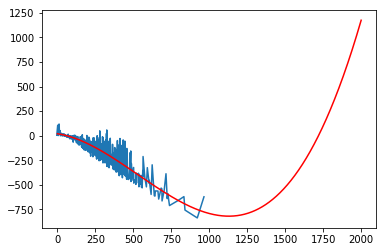

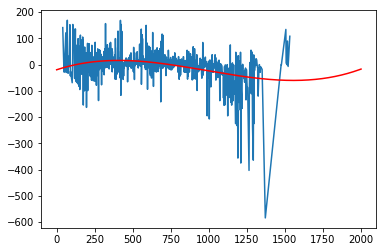

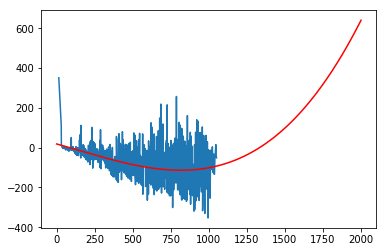

In [72]:
x = np.linspace(0,2000,2000)


polynom = np.poly1d(np.polyfit(Xmin_med_err.index, Xmin_med_err.Xmin_med_err, 3))
y = polynom(x)

plt.figure()
plt.plot(Xmin_med_err)
plt.plot(x,y, 'r')


polynom = np.poly1d(np.polyfit(Ymin_med_err.index, Ymin_med_err.Ymin_med_err, 3))
y = polynom(x)

plt.figure()
plt.plot(Ymin_med_err)
plt.plot(x,y, 'r')


polynom = np.poly1d(np.polyfit(Xmax_med_err.index, Xmax_med_err.Xmax_med_err, 3))
y = polynom(x)

plt.figure()
plt.plot(Xmax_med_err)
plt.plot(x,y, 'r')


polynom = np.poly1d(np.polyfit(Ymax_med_err.index, Ymax_med_err.Ymax_med_err, 6))
y = polynom(x)

plt.figure()
plt.plot(Ymax_med_err)
plt.plot(x,y, 'r')



In [73]:
polynom_Xmin_med_err = np.poly1d(np.polyfit(Xmin_med_err.index, Xmin_med_err.Xmin_med_err, 3))
polynom_Ymin_med_err = np.poly1d(np.polyfit(Ymin_med_err.index, Ymin_med_err.Ymin_med_err, 3))
polynom_Xmax_med_err = np.poly1d(np.polyfit(Xmax_med_err.index, Xmax_med_err.Xmax_med_err, 3))
polynom_Ymax_med_err = np.poly1d(np.polyfit(Ymax_med_err.index, Ymax_med_err.Ymax_med_err, 6))

def apply_xy_correctorbyError(data):
    data.Xmin += polynom_Xmin_med_err(data.Xmin)
    data.Ymin += polynom_Ymin_med_err(data.Ymin)
    data.Xmax += polynom_Xmax_med_err(data.Xmax)
    data.Ymax += polynom_Ymax_med_err(data.Ymax)
    
    return data
# П: 0.5121282


In [48]:
temp = data.sort_values(by='perimetr')

plt.figure(figsize=(10,10))
# plt.plot(data.Xmin, data.Xmin_true, '.')
# sns.jointplot("Xmin", "c", data=data, kind="reg")
sns.scatterplot(x='Xmin', y='Xmin_true', hue='perimetr', data=temp)

# sns.jointplot("Xmin", "Xmin_true", data=data, kind="reg")

x = np.linspace(100,300,3)
y = np.tan(45*3.14/180) * (x - 100)
plt.plot(x,y, 'r')

plt.axis('square')

(-52.4506505376344,
 1013.4506505376344,
 -22.750667770419426,
 1043.1506333048494)

In [164]:
print(data['Xmin_err'].mean(), data['Ymin_err'].mean(), data['Xmax_err'].mean(), data['Ymax_err'].mean())
print(data['Xmin_err'].min(), data['Ymin_err'].min(), data['Xmax_err'].min(), data['Ymax_err'].min())
print(data['Xmin_err'].max(), data['Ymin_err'].max(), data['Xmax_err'].max(), data['Ymax_err'].max())

sns.distplot(data['Xmin_err'],  hist=False, rug=False, label='Xmin_err')
sns.distplot(data['Xmax_err'],  hist=False, rug=False, label='Xmax_err')
sns.distplot(data['Ymin_err'],  hist=False, rug=False, label='Ymin_err')
sns.distplot(data['Ymax_err'],  hist=False, rug=False, label='Ymax_err')

plt.legend()

-34.824508320726174 -21.31108169440242 32.88861573373676 26.82469742813918
-838 -584 -353 -428
326 257 828 837


/home/ivan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [16]:
# Значение Медианной Коррекции для пользователя
Xmin_med_err = data.groupby('userId')['Xmin_err'].median()
Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
data = data.merge(right=Xmin_med_err, how='inner', left_on='userId', right_index=True)
del Xmin_med_err

Ymin_med_err = data.groupby('userId')['Ymin_err'].median()
Ymin_med_err = pd.DataFrame(Ymin_med_err);  Ymin_med_err.columns = ['Ymin_med_err']
data = data.merge(right=Ymin_med_err, how='inner', left_on='userId', right_index=True)
del Ymin_med_err

Xmax_med_err = data.groupby('userId')['Xmax_err'].median()
Xmax_med_err = pd.DataFrame(Xmax_med_err);  Xmax_med_err.columns = ['Xmax_med_err']
data = data.merge(right=Xmax_med_err, how='inner', left_on='userId', right_index=True)
del Xmax_med_err

Ymax_med_err = data.groupby('userId')['Ymax_err'].median()
Ymax_med_err = pd.DataFrame(Ymax_med_err);  Ymax_med_err.columns = ['Ymax_med_err']
data = data.merge(right=Ymax_med_err, how='inner', left_on='userId', right_index=True)
del Ymax_med_err

In [612]:
data.sort_values('userId')

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
3902       0   21299    44   157   748   657        283        186        768   
2208       0   21223    32   602   294   795         32        597        314   
4953       2   21231    53   746   327  1026         73        686        408   
2203       2   21223    41   657   233   767         32        597        314   
1104       2   21296   181   874   398  1042         39        734        500   
3901       2   21299   301   238   679   559        283        186        768   
1026       3   12466    54   481   137   554         22        475        206   
1367       3   12433    32   575   152   667         64        591        160   
1406       3   10273    27   548   294   739        114        550        247   
1454       3   12796    46   668   775  1383        276        683       1047   
1940       3   12975   144   962   556  1128        115        916        414   
2995       3   12908   310   588   910  1180        383        753        765   
3210       3   10201    41   270   392   458        147        289        321   
3344       3   12488    29   325   481   910         21        321        631   
3840       3   10878    56   464   115   565         39        484        117   
532        3   12701    48   870   462  1176         40        856        469   
4722       3   10255    55  1084    61  1097         60       1081         78   
5254       3   12831   139  1064   342  1191         93       1080        321   
4084       3   12780    33   950   305  1111        130        931        314   
4587       3   12788   106   603   418   865         26        559        440   
2954       5    6219    67   470   203   677         23        465        176   
212        7   33084    53   642   346   940         67        647        428   
2961       7   33024    47   642   657   843        239        627        708   
4634       8   29563   120   957   221  1078        104        965        275   
3822      10   26565   224   879   894  1397        256        956        671   
3681      10   29178   209   801   644  1183         60        839        481   
2766      10   29200   153   251   744   801        105        159        862   
2200      10   29123    45   521   212   636         61        525        169   
1830      10   29182   139   995   391  1190         63       1005        343   
1786      10   29174    69   978   201  1088         52        982        205   
...      ...     ...   ...   ...   ...   ...        ...        ...        ...   
2162    1741   30200    88   875   456  1174         75        912        452   
2606    1741    7617    57   779   193   909         38        775        240   
4193    1741   25815    99   505   886  1066        243        569        681   
2297    1741   30121    46   450   417   782        158        442        342   
4791    1742   26492    65   729   363   987         25        723        425   
1152    1743   28172   237   295   541   695          9        215        613   
275     1743   10732   172   527   420   714         49        536        477   
48      1743   11109    58   593   481  1082        141        561        732   
41      1743   10766    60   172   479   635          3        179        682   
3099    1743   10358   195   487   431   817         48        482        587   
4757    1744    7673    94   972   352  1219        121       1029        433   
3647    1745    5389    49   462    73   475         42        444         63   
4018    1745    5312    58   822    76   855         48        819         87   
3968    1746   24662    61  1509    87  1553         59       1514         80   
4717    1748   29906    63   946   168  1035         69        941        188   
1473    1748   29956    58   687   241   829         98        708        262   
2280    1748   30112    96   452   854   932         70        604        912   
2298    1748   30121    60   458   39

In [640]:
tmp

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
532        3   12701    48   870   462  1176         40        856        469   
1026       3   12466    54   481   137   554         22        475        206   
1367       3   12433    32   575   152   667         64        591        160   
1406       3   10273    27   548   294   739        114        550        247   
1454       3   12796    46   668   775  1383        276        683       1047   
1940       3   12975   144   962   556  1128        115        916        414   
2995       3   12908   310   588   910  1180        383        753        765   
3210       3   10201    41   270   392   458        147        289        321   
3344       3   12488    29   325   481   910         21        321        631   
3840       3   10878    56   464   115   565         39        484        117   
4084       3   12780    33   950   305  1111        130        931        314   
4587       3   12788   106   603   418   865         26        559        440   
4722       3   10255    55  1084    61  1097         60       1081         78   
5254       3   12831   139  1064   342  1191         93       1080        321   

      Ymax_true  Xmin_err  Ymin_err  Xmax_err  Ymax_err  Xmin_med_err  \
532        1176        -8       -14         7         0          -1.5   
1026        625       -32        -6        69        71          -1.5   
1367        658        32        16         8        -9          -1.5   
1406        693        87         2       -47       -46          -1.5   
1454       1319       230        15       272       -64          -1.5   
1940       1235       -29       -46      -142       107          -1.5   
2995       1116        73       165      -145       -64          -1.5   
3210        479       106        19       -71        21          -1.5   
3344        772        -8        -4       150      -138          -1.5   
3840        583       -17        20         2        18          -1.5   
4084       1145        97       -19         9        34          -1.5   
4587        819       -80       -44        22       -46          -1.5   
4722       1099         5        -3        17         2          -1.5   
5254       1225       -46        16       -21        34          -1.5   

      Ymin_med_err  Xmax_med_err  Ymax_med_err  
532           -0.5           7.5           1.0  
1026          -0.5           7.5           1.0  
1367          -0.5           7.5           1.0  
1406          -0.5           7.5           1.0  
1454          -0.5           7.5           1.0  
1940          -0.5           7.5           1.0  
2995          -0.5           7.5           1.0  
3210          -0.5           7.5           1.0  
3344          -0.5           7.5           1.0  
3840          -0.5           7.5           1.0  
4084          -0.5           7.5           1.0  
4587          -0.5           7.5           1.0  
4722          -0.5           7.5           1.0  
5254          -0.5           7.5           1.0

In [25]:
plt.axis?

In [34]:
tmp_usr = 3
tmp = data[data['userId'] == tmp_usr]

plt.figure()
fig,ax = plt.subplots(1)

for x_min, y_min, x_max, y_max in zip(tmp['Xmin'],tmp['Ymin'],tmp['Xmax'],tmp['Ymax']):
    rect = patches.Rectangle((x_min, y_min),x_max-x_min, y_max-y_min,
                             linewidth=1, edgecolor='r',facecolor='none', alpha=.3)
    ax.add_patch(rect)
    
# plt.axis((0,max(tmp['Xmax']+5),0,max(tmp['Ymax']+5)))
plt.axis('square')
plt.show()


# del tmp_usr, fig, ax

<Figure size 432x288 with 0 Axes>

In [605]:
'''
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou', 'mean_user_iou',
       'sum_user_iou', 'Xmin_err', 'Ymin_err', 'Xmax_err', 'Ymax_err',
       'Xmin_med_err', 'Ymin_med_err', 'Xmax_med_err', 'Ymax_med_err'],
      dtype='object')
'''

data.sort_values(['userId'])[['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true']]


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2208       0   21223    32   602   294   795         32        597        314   
3902       0   21299    44   157   748   657        283        186        768   
4953       2   21231    53   746   327  1026         73        686        408   
2203       2   21223    41   657   233   767         32        597        314   
3901       2   21299   301   238   679   559        283        186        768   
1104       2   21296   181   874   398  1042         39        734        500   
3840       3   10878    56   464   115   565         39        484        117   
2995       3   12908   310   588   910  1180        383        753        765   
1940       3   12975   144   962   556  1128        115        916        414   
1367       3   12433    32   575   152   667         64        591        160   
3210       3   10201    41   270   392   458        147        289        321   
4722       3   10255    55  1084    61  1097         60       1081         78   
1454       3   12796    46   668   775  1383        276        683       1047   
5254       3   12831   139  1064   342  1191         93       1080        321   
1406       3   10273    27   548   294   739        114        550        247   
4587       3   12788   106   603   418   865         26        559        440   
1026       3   12466    54   481   137   554         22        475        206   
532        3   12701    48   870   462  1176         40        856        469   
3344       3   12488    29   325   481   910         21        321        631   
4084       3   12780    33   950   305  1111        130        931        314   
2954       5    6219    67   470   203   677         23        465        176   
2961       7   33024    47   642   657   843        239        627        708   
212        7   33084    53   642   346   940         67        647        428   
4634       8   29563   120   957   221  1078        104        965        275   
2200      10   29123    45   521   212   636         61        525        169   
1253      10   29167    78   701   473   973         35        749        388   
1786      10   29174    69   978   201  1088         52        982        205   
1830      10   29182   139   995   391  1190         63       1005        343   
2766      10   29200   153   251   744   801        105        159        862   
3681      10   29178   209   801   644  1183         60        839        481   
...      ...     ...   ...   ...   ...   ...        ...        ...        ...   
2297    1741   30121    46   450   417   782        158        442        342   
2606    1741    7617    57   779   193   909         38        775        240   
2162    1741   30200    88   875   456  1174         75        912        452   
4193    1741   25815    99   505   886  1066        243        569        681   
4791    1742   26492    65   729   363   987         25        723        425   
1152    1743   28172   237   295   541   695          9        215        613   
41      1743   10766    60   172   479   635          3        179        682   
275     1743   10732   172   527   420   714         49        536        477   
3099    1743   10358   195   487   431   817         48        482        587   
48      1743   11109    58   593   481  1082        141        561        732   
4757    1744    7673    94   972   352  1219        121       1029        433   
4018    1745    5312    58   822    76   855         48        819         87   
3647    1745    5389    49   462    73   475         42        444         63   
3968    1746   24662    61  1509    87  1553         59       1514         80   
1473    1748   29956    58   687   241   829         98        708        262   
2298    1748   30121    60   458   397   750        158        442        342   
4717    1748   29906    63   946   168  1035         69        941        188   
4017    1748    5312    51   819    9

In [606]:
data.sort_values(['userId'])[['userId', 'itemId', 'iou', 'mean_user_iou',
       'sum_user_iou', 'Xmin_err', 'Ymin_err', 'Xmax_err', 'Ymax_err',
       'Xmin_med_err', 'Ymin_med_err', 'Xmax_med_err', 'Ymax_med_err']]

userId  itemId       iou  mean_user_iou  sum_user_iou  Xmin_err  \
2208       0   21223  0.857379       0.709711      1.419422         0   
3902       0   21299  0.562043       0.709711      1.419422       239   
4953       2   21231  0.322452       0.375443      1.501773        20   
2203       2   21223  0.400501       0.375443      1.501773        -9   
3901       2   21299  0.573811       0.375443      1.501773       -18   
1104       2   21296  0.205010       0.375443      1.501773      -142   
3840       3   10878  0.536846       0.459124      6.427731       -17   
2995       3   12908  0.390389       0.459124      6.427731        73   
1940       3   12975  0.376787       0.459124      6.427731       -29   
1367       3   12433  0.509330       0.459124      6.427731        32   
3210       3   10201  0.422245       0.459124      6.427731       106   
4722       3   10255  0.033419       0.459124      6.427731         5   
1454       3   12796  0.457147       0.459124      6.427731       230   
5254       3   12831  0.522840       0.459124      6.427731       -46   
1406       3   10273  0.372944       0.459124      6.427731        87   
4587       3   12788  0.552430       0.459124      6.427731       -80   
1026       3   12466  0.219529       0.459124      6.427731       -32   
532        3   12701  0.922815       0.459124      6.427731        -8   
3344       3   12488  0.598674       0.459124      6.427731        -8   
4084       3   12780  0.512338       0.459124      6.427731        97   
2954       5    6219  0.424744       0.424744      0.424744       -44   
2961       7   33024  0.234393       0.479601      0.959203       192   
212        7   33084  0.724810       0.479601      0.959203        14   
4634       8   29563  0.560802       0.560802      0.560802       -16   
2200      10   29123  0.545483       0.554050      3.878348        16   
1253      10   29167  0.553113       0.554050      3.878348       -43   
1786      10   29174  0.794224       0.554050      3.878348       -17   
1830      10   29182  0.434857       0.554050      3.878348       -76   
2766      10   29200  0.649948       0.554050      3.878348       -48   
3681      10   29178  0.379625       0.554050      3.878348      -149   
...      ...     ...       ...            ...           ...       ...   
2297    1741   30121  0.253907       0.522385      2.089540       112   
2606    1741    7617  0.616371       0.522385      2.089540       -19   
2162    1741   30200  0.728193       0.522385      2.089540       -13   
4193    1741   25815  0.491068       0.522385      2.089540       144   
4791    1742   26492  0.484156       0.484156      0.484156       -40   
1152    1743   28172  0.415960       0.412405      2.062025      -228   
41      1743   10766  0.571496       0.412405      2.062025       -57   
275     1743   10732  0.310462       0.412405      2.062025      -123   
3099    1743   10358  0.344023       0.412405      2.062025      -147   
48      1743   11109  0.420084       0.412405      2.062025        83   
4757    1744    7673  0.390990       0.390990      0.390990        27   
4018    1745    5312  0.409692       0.302906      0.605812       -10   
3647    1745    5389  0.196121       0.302906      0.605812        -7   
3968    1746   24662  0.473422       0.473422      0.473422        -2   
1473    1748   29956  0.579029       0.594843      2.974213        40   
2298    1748   30121  0.297746       0.594843      2.974213        98   
4717    1748   29906  0.626362       0.594843      2.974213         6   
4017    1748    5312  0.837209       0.594843      2.974213        -3   
2280    1748   30112  0.633867       0.594843      2.974213       -26   
4989    1750   35868  0.406565       0.493804      3.456630        52   
3479    1750    1095  0.545455       0.493804      3.456630         1   
1748    1750     572  0.528948       0.493804      3.456630       -22   
3924    1750    1024  0.454846       0.493804      3.456630     

In [574]:
tmp_it = 6132 # 35868
q = 5
tmp = data[data['itemId'] == tmp_it]['Xmin_err']
print( np.mean(tmp), 
       np.median(tmp),
      np.median(tmp) + q, np.median(tmp) - q
     )

print(data[data['itemId'] == tmp_it])

del tmp, tmp_it

-39.5 -15.5 -10.5 -20.5
   userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   
5    1092    6132    39   649   249   825         47        650        213   

   Ymax_true      ...       mean_user_iou  sum_user_iou  Xmin_err  Ymin_err  \
0        812      ...            0.469767      1.409301       -15        -6   
1        812      ...            0.395544      1.186631      -137       -12   
2        812      ...            0.578063      3.468375       -16         2   
3        812      ...            0.481137      3.367958       -64        13   
4        812      ...            0

In [333]:
data.quantile?

Гипотеза: если Юзеры ошибаются, значит есть проблема в самой картинке. Если мы будем добавлять среднее отклонение ошибки к тому, что прогнозят люди, то это улучшит прогноз. Но это нужно делать для тех юзеров, которые сделали такую же оценку, как и тех, среднее которых я считаю

Гипотеза не сработает, потому что в тесте новые картинки. Тут дело в юзерах.

In [524]:
data[data['userId'] == 1573]

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
690     1573   31634   156   591   406  1004         21        662        668   
842     1573   31398   154   525   462   824         20        512        744   
849     1573   31392    49   656   157   829         32        611        749   
854     1573    1751   103   516   444   677         27        510        588   
1688    1573   31443    82   335   287   482         15        318        267   
1862    1573   27005    88  1000   416  1152         41        953        423   
2468    1573   26191   111   297   186   404        122        267        445   
2642    1573   31018    72   559   113   616         55        565        120   
2957    1573      30   124   374   286   468         61        368        329   
4218    1573      90   134   269   428   537        103        372        324   
5032    1573      78   120   204   575   707          4        105        816   

      Ymax_true       iou  mean_user_iou  sum_user_iou  Xmin_err  Ymin_err  \
690        1219  0.226113       0.312481      3.437293      -135        71   
842        1020  0.250392       0.312481      3.437293      -134       -13   
849        1087  0.054745       0.312481      3.437293       -17       -45   
854         883  0.262367       0.312481      3.437293       -76        -6   
1688        510  0.529869       0.312481      3.437293       -67       -17   
1862       1309  0.366610       0.312481      3.437293       -47       -47   
2468        570  0.069140       0.312481      3.437293        11       -30   
2642        622  0.529233       0.312481      3.437293       -17         6   
2957        530  0.350746       0.312481      3.437293       -63        -6   
4218        542  0.368771       0.312481      3.437293       -31       103   
5032        644  0.429307       0.312481      3.437293      -116       -99   

      Xmax_err  Ymax_err  
690        262       215  
842        282       196  
849        592       258  
854        144       206  
1688       -20        28  
1862         7       157  
2468       259       166  
2642         7         6  
2957        43        62  
4218      -104         5  
5032       241       -63

### сколько и кого нет в трейновом списке?

Есть ли новые юзеры/картинки в тестовой выборке? сколько их?

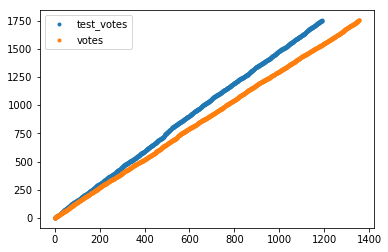

In [25]:
plt.figure
plt.plot(sorted(test_votes['userId'].unique()), '.', label='test_votes')
plt.plot(sorted(votes['userId'].unique()), '.', label='votes')
plt.legend() 

Кого из тестовой выборки нет в трейне:

In [ ]:
i=0
for it in test_votes['userId'].unique():
    if not it in votes['userId'].unique():
        print(i, it)
        i=i+1

Каких изображений из тестовой выборки нет в трейне:

In [ ]:
i=0
for it in test_votes['itemId'].unique():
    if not it in votes['itemId'].unique():
        print(i, it)
        i=i+1

В новой выборке картинки новые, но пересекаются пользователи

### Средняя точность юзера

In [507]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', \
      'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
data.head(10)

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
1       1399    6132   184   662   235   740         47        650        213   
2425    1399    5778   333   860   589  1114        198        815        581   
4383    1399    5797    86   328   591   874          6        326        541   
2       1694    6132    63   648   272   830         47        650        213   
2429    1694    5778   288   830   585  1206        198        815        581   
3927    1694    1024   104   635   250   798         33        619        226   
4009    1694     576   187   477   515   824         96        467        520   

      Ymax_true       iou  mean_user_iou  sum_user_iou  Xmin_err  Ymin_err  \
0           812  0.613974       0.469767      1.409301        15         6   
1580       1226  0.293820       0.469767      1.409301        99       193   
2430       1198  0.501507       0.469767      1.409301       106        41   
1           812  0.079069       0.395544      1.186631       137        12   
2425       1198  0.423558       0.395544      1.186631       135        45   
4383        801  0.684004       0.395544      1.186631        80         2   
2           812  0.598080       0.578063      3.468375        16         2   
2429       1198  0.716262       0.578063      3.468375        90        15   
3927        816  0.474233       0.578063      3.468375        71        16   
4009        792  0.696715       0.578063      3.468375        91        10   

      Xmax_err  Ymax_err  
0           63         9  
1580       186       378  
2430        34        59  
1           22        72  
2425         8        84  
4383        50        73  
2           59        18  
2429         4         8  
3927        24        18  
4009         5        32

In [481]:
#  Средняя точность юзера
mean_user_iou = data.groupby("userId")['iou'].mean()
mean_user_iou = pd.DataFrame(mean_user_iou)
mean_user_iou.columns = ['mean_user_iou']
data = data.merge(right=mean_user_iou, how='inner', left_on='userId', right_index=True)
del mean_user_iou

sum_user_iou = data.groupby("userId")['iou'].sum()
sum_user_iou = pd.DataFrame(sum_user_iou)
sum_user_iou.columns = ['sum_user_iou']
data = data.merge(right=sum_user_iou, how='inner', left_on='userId', right_index=True)
del sum_user_iou

data.head(20)

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
1       1399    6132   184   662   235   740         47        650        213   
2425    1399    5778   333   860   589  1114        198        815        581   
4383    1399    5797    86   328   591   874          6        326        541   
2       1694    6132    63   648   272   830         47        650        213   
2429    1694    5778   288   830   585  1206        198        815        581   
3927    1694    1024   104   635   250   798         33        619        226   
4009    1694     576   187   477   515   824         96        467        520   
4384    1694    5797    39   296   690   947          6        326        541   
5008    1694     511    80   782   203   923         55        827        181   
3        916    6132   111   637   253   831         47        650        213   
1047     916    6646    38   535   346   808         16        521        355   
1582     916    6171   124   477   922   941         24        258       1029   
2148     916    6606    75   246   651   611          3        151        717   
2212     916    6665    45   850    80   877         36        843         86   
2431     916    5778   306   816   643  1160        198        815        581   
3762     916    6162   132   832   477  1149         41        775        589   
4       1621    6132    60   651   242   819         47        650        213   

      Ymax_true       iou  mean_user_iou  sum_user_iou  
0           812  0.613974       0.469767      1.409301  
1580       1226  0.293820       0.469767      1.409301  
2430       1198  0.501507       0.469767      1.409301  
1           812  0.079069       0.395544      1.186631  
2425       1198  0.423558       0.395544      1.186631  
4383        801  0.684004       0.395544      1.186631  
2           812  0.598080       0.578063      3.468375  
2429       1198  0.716262       0.578063      3.468375  
3927        816  0.474233       0.578063      3.468375  
4009        792  0.696715       0.578063      3.468375  
4384        801  0.542578       0.578063      3.468375  
5008        941  0.440507       0.578063      3.468375  
3           812  0.435805       0.481137      3.367958  
1047       1013  0.504137       0.481137      3.367958  
1582       1226  0.380609       0.481137      3.367958  
2148        681  0.555573       0.481137      3.367958  
2212        886  0.439535       0.481137      3.367958  
2431       1198  0.563038       0.481137      3.367958  
3762       1112  0.489260       0.481137      3.367958  
4           812  0.750206       0.440480      2.202400

In [30]:
#  для проверки
# data[data['userId'] == 1694]

(Text(0, 0.5, 'sum_user_iou'), Text(0.5, 0, 'sorted(data.sum_user_iou)'))

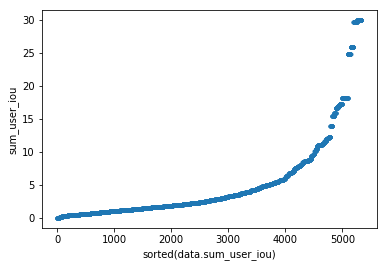

In [439]:
plt.figure()
plt.plot(sorted(data.mean_user_iou), '.')
plt.ylabel('mean_user_iou'), plt.xlabel('sorted(data.mean_user_iou)')

plt.figure()
plt.plot(sorted(data.sum_user_iou), '.')
plt.ylabel('sum_user_iou'), plt.xlabel('sorted(data.sum_user_iou)')

### Средние площади и площади пересечения юзеров

In [664]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)


In [665]:
data.head()

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   

   Ymax_true       iou   area  area_true  
0        812  0.613974  31458      26892  
1        812  0.079069   3978      26892  
2        812  0.598080  38038      26892  
3        812  0.435805  27548      26892  
4        812  0.750206  30576      26892

In [666]:
temp = data.sort_values(by='area')

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(temp['area'], temp['Xmin'], '.')
plt.legend()

plt.subplot(132)
plt.plot((temp['area']), '.', label='area')
plt.plot((temp['area_true']), '.', label='area_true')
plt.legend()

plt.subplot(133)
plt.plot(temp['area'],temp['area_true'], '.')

In [580]:
sns.scatterplot?

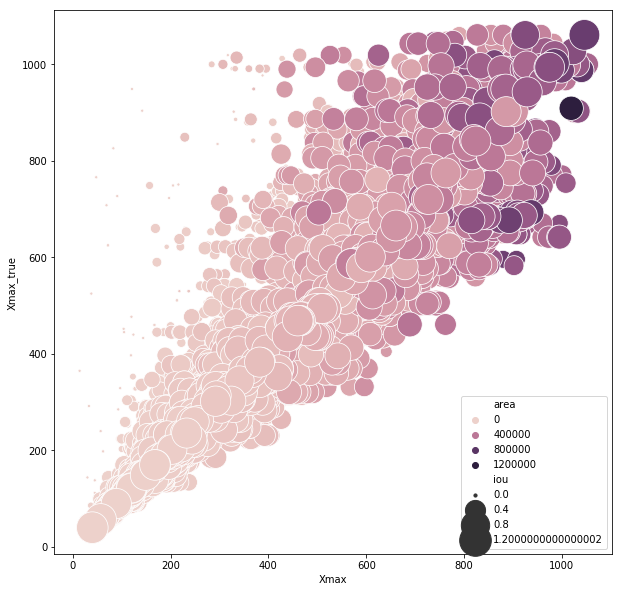

In [628]:
temp = data.sort_values(by='iou')
# temp['areaLog'] = np.exp(temp['area'])

plt.figure(figsize=(10,10))
sns.scatterplot(x='Xmax', y='Xmax_true', size='iou', hue='area', data=temp, sizes=(10,1000))

In [22]:
plt.axis?

In [557]:
temp.head(50)

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2560     245   18167    45   504    45   505         53        494        138   
4164     941   25135    45  1243    45  1243         45       1243         45   
4165    1539   25135    45  1243    45  1243         45       1243         45   
4166    1123   25135    45  1243    45  1243         45       1243         45   
4167     639   25135    45  1243    45  1243         45       1243         45   
4168     957   25135    45  1243    45  1243         45       1243         45   
4169     952   25135    45  1243    45  1243         45       1243         45   
4727    1324   10255    75  1099    75  1099         60       1081         78   
3963     921   16852   100   704   100   704         65        715        100   
3722    1351   32431   110   446   111   446         25        444         94   
5202    1671   31033    47   963    48   963         47        963         48   
5201     859   31033    47   963    48   963         47        963         48   
5200     909   31033    47   963    48   963         47        963         48   
2608     712    7617    56   788    57   788         38        775        240   
3132    1210   19388    91   972    91   972         63        975         90   
3475     718    1095    34   601    41   601         35        599         41   
3328    1134     118   168  1274   168  1275         46       1277        143   
577      860   26654    29   563    30   564         71        570        144   
3544     291   25142    56  1476    57  1477         55       1475         57   
3888     952   23181   204   912   205   913         30        854        324   
572      952    7090   245   919   246   920         37        811        400   
4843    1037   13209    61   797    62   798         39        766        198   
5009     607     511   146   798   147   799         55        827        181   
1476     719   29956   174   774   175   775         98        708        262   
4868    1470   22483    37   768    38   769         37        768         40   
4584    1102   12788   123   603   124   604         26        559        440   
23      1165   29286    96   602    97   603         34        593        148   
1905    1681   14215    98  1013    99  1014         44        928        218   
772      517    9323    99   550   100   551         24        529        153   
5262     681    5466    32   480    33   481         30        475        292   
4870    1222   22483    38   768    39   769         37        768         40   
2242    1723    5676   186   927   187   928         59        921        218   
4867    1595   22483    38   768    39   769         37        768         40   
2158     723   30200   102   887   104   888         75        912        452   
3431    1068   17622   440   262   441   264        211        338        435   
1130     209   16118   183   819   185   820         56        798        272   
2618     590   30204   135  1186   136  1188         37       1031        233   
5145     854   20098   286   759   287   761        129        749        376   
5061    1720   18374   117   617   119   618         35        596        397   
3548     952   25142    55  1476    57  1477         55       1475         57   
453      741   13336    13   240    14   242        108        253        365   
830     1197   11258    39   579    41   580         32        577         41   
2956     141      30    96   367    97   369         61        368        329   
3858     969    6013    53   931    56   932         48        924         67   
5059     569   18374   448   563   450   565         35        596        397   
3203    1324   10201   385   363   387   365        147        289        321   
3542     941   25142    55  1476    57  1478         55       1475         57   
149      931    4927   586  1264   588  1266         92        861        601   
4863     473   20028    36   355    3

Тестовая выборка, что там?

In [559]:
temp = test_votes
temp['area'] = test_votes[['Xmin','Ymin', 'Xmax', 'Ymax']].apply(area, axis=1)

In [566]:
selected = temp[temp['area'] < 3].index
temp.iloc[selected].sort_values(by=['itemId'])

userId  itemId  Xmin  Ymin  Xmax  Ymax  area
463     1311     492   209  1104   210  1105     1
2819     607    1065   342   865   343   867     2
357     1131    5066    25   702    26   702     0
358     1489    5066    25   702    26   702     0
359      577    5066    26   701    26   702     0
360     1540    5066    25   701    27   702     2
361     1428    5066    25   702    26   702     0
362      420    5066    25   702    26   702     0
363      475    5066    25   702    26   702     0
364       11    5066    26   702    26   702     0
365      478    5066    26   702    26   702     0
769      947    5970    33   366    34   367     1
51       760    7384   114   935   115   936     1
2492     166    7629    62   751    63   752     1
2123    1145    7778   162  1007   163  1007     0
3323     140    8841   177   596   179   597     2
2658     739   13369   384   983   386   984     2
2507    1577   16036    57   876    57   876     0
3044    1501   16625   429  1123   430  1125     2
1333     245   18191    55  1372    55  1373     0
1761     317   18573   290   721   291   722     1
940      317   18593   241   651   242   652     1
2017     855   18781   313   880   314   881     1
2481     584   25482    47   394    48   395     1
1160     671   25997    32   533    33   534     1
1925    1311   26394   389   430   390   431     1
3290     314   29271   366   814   367   816     2
2058     719   29961    89   520    91   521     2
2070     719   29976   119   438   119   439     0
2075     723   29976    67   394    68   395     1

In [ ]:
# temp = data.sort_values(by='area')
temp = temp.sort_values(by=['area', 'itemId'])
plt.figure(figsize=(15,5))
plt.subplot(131)
# plt.plot(temp[:25]['area'], temp[:25]['area_true'], '.')
plt.legend()
plt.subplot(132)
plt.plot((temp['area']), '.', label='area')
# plt.plot((temp['area_true']), '.', label='area_true')
plt.legend()
plt.subplot(133)
# plt.plot(temp['area'],temp['area_true'], '.')


<Figure size 432x288 with 0 Axes>

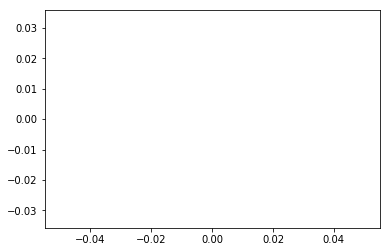

In [160]:
draw_box(1210, 19388)

(-58.46721433402706, 1013.7371535755577, -126.77848107655983, 945.425886833025)

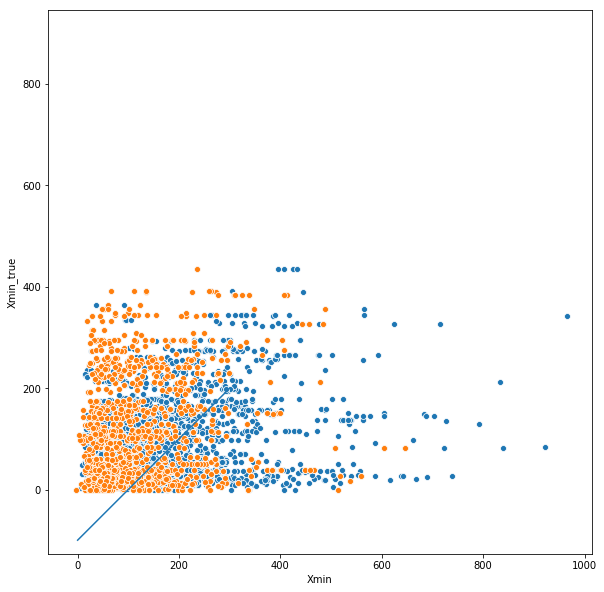

In [36]:
temp = data.sort_values(by='area')
# temp['areaLog'] = temp['area']*temp['Xmin']

plt.figure(figsize=(10,10))
sns.scatterplot(x='Xmin', y='Xmin_true', data=temp)
x = np.linspace(0,300,3)
y = np.tan(45*3.14/180) * (x - 100)
plt.plot(x,y)

sns.scatterplot(x='Xmin', y='Xmin_true',  data=temp[temp['area'] > 200000])

plt.axis('square')

### Средняя точность картинки

In [35]:
#  Средняя точность картинки
mean_item_iou = data.groupby("itemId")['iou'].mean()
mean_item_iou = pd.DataFrame(mean_item_iou)
mean_item_iou.columns = ['mean_item_iou']

data = data.merge(right=mean_item_iou, how='inner', left_on='itemId', right_index=True)
data.head(20)

userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1       1399    6132   184   662   235   740         47        650        213   
2       1694    6132    63   648   272   830         47        650        213   
3        916    6132   111   637   253   831         47        650        213   
4       1621    6132    60   651   242   819         47        650        213   
5       1092    6132    39   649   249   825         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
1582     916    6171   124   477   922   941         24        258       1029   
1576    1621    6171   145   553   842   868         24        258       1029   
1577    1092    6171    87   371   931   965         24        258       1029   
1579      52    6171   140   435   886   988         24        258       1029   
1578    1459    6171   689   668   790   827         24        258       1029   
1581     540    6171   120   443   905   941         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
2425    1399    5778   333   860   589  1114        198        815        581   
2429    1694    5778   288   830   585  1206        198        815        581   
2431     916    5778   306   816   643  1160        198        815        581   
2423    1092    5778   292   796   694  1191        198        815        581   
2424    1097    5778   242   809   679  1195        198        815        581   
2427    1459    5778   310   825   652  1161        198        815        581   

      Ymax_true       iou  mean_user_iou  mean_item_iou  
0           812  0.613974       0.469767       0.534122  
1           812  0.079069       0.395544       0.534122  
2           812  0.598080       0.578063       0.534122  
3           812  0.435805       0.481137       0.534122  
4           812  0.750206       0.440480       0.534122  
5           812  0.727597       0.502819       0.534122  
1580       1226  0.293820       0.469767       0.322550  
1582       1226  0.380609       0.481137       0.322550  
1576       1226  0.225685       0.440480       0.322550  
1577       1226  0.515332       0.502819       0.322550  
1579       1226  0.424055       0.580446       0.322550  
1578       1226  0.016507       0.319879       0.322550  
1581       1226  0.401844       0.585730       0.322550  
2430       1198  0.501507       0.469767       0.537061  
2425       1198  0.423558       0.395544       0.537061  
2429       1198  0.716262       0.578063       0.537061  
2431       1198  0.563038       0.481137       0.537061  
2423       1198  0.552112       0.502819       0.537061  
2424       1198  0.690535       0.537014       0.537061  
2427       1198  0.533912       0.319879       0.537061

In [36]:
#  для проверки
# data[data['itemId'] == 6132]

(Text(0, 0.5, 'mean_item_iou'), Text(0.5, 0, 'sorted(data.mean_item_iou)'))

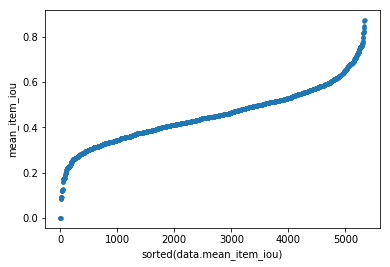

In [37]:
plt.figure()
plt.plot(sorted(data.mean_item_iou), '.')
plt.ylabel('mean_item_iou'), plt.xlabel('sorted(data.mean_item_iou)')

In [23]:


# группировать юзеров по точности
а если его нет в выборке, то какие критерии? смотреть на показания и сравнивать с "качеством" тех юзеров, что известны?


# выбирать картинки, где низкая точность, т.е. группировать хорошие/плохие картинки

SyntaxError: invalid syntax (<ipython-input-23-a7a036ae8d2d>, line 4)

# Прогноз

## Среднее - baseline

считаем средние голоса всех участников - это ответ

In [90]:
quorum = votes.groupby("itemId")[['Xmin','Ymin', 'Xmax', 'Ymax']].mean().reset_index()

data = quorum.merge(answers, on=["itemId"])
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', \
      'Xmin_true','Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

data["iou"].mean()

0.5058725791429202

In [28]:
quorum = test_votes.groupby("itemId")[['Xmin','Ymin', 'Xmax', 'Ymax']].mean().reset_index()

quorum.head(10)

itemId        Xmin        Ymin        Xmax         Ymax
0      18  135.000000  704.000000  729.000000  1071.000000
1      19   29.666667  560.666667  114.666667   725.666667
2      33   46.333333  393.666667  374.666667   633.666667
3      62   90.857143  964.857143  564.000000  1167.571429
4     114   63.333333  575.000000  207.666667   767.000000
5     146   72.000000  481.375000  577.375000   816.750000
6     156   84.333333  805.333333  155.000000   880.333333
7     163   33.333333  322.166667  203.333333   453.833333
8     164    9.333333  148.666667  366.333333   659.666667
9     179  126.000000  512.333333  322.333333   729.000000

In [32]:
quorum.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

del quorum, data

## МинМин-МаксМакс

Делаем предикт

In [818]:
res = predictByMinMax(votes)
res.head()

itemId  Xmin  Ymin  Xmax  Ymax
0       5   161   914   511  1331
1      10    82   559   427   858
2      13    56   600   621   981
3      30    75   353   324   491
4      32    19   279   388   884

Проверяем результат на трейне

In [819]:
local_miou_score(res)

0.5624569305987238

In [ ]:
0.5809800227327839 начальный МинМинМаксМакс


Предикт Теста:

In [200]:
res = predictByMinMax(test_votes)
res.head(10)

itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [201]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

del res

## Квантиль, медиана

"МинМин-МаксМакс" делает большую площадь, на которую надо потом делить ( IoU = a*b/(a+b) ). Таким образом, мы вроде как берём площадь в которую вероятнее всего попадёт большая часть верного, но при это будет и большая часть не имеющего значения. Тогда давайте отсекать то, за что большинство не проголосовало. 

**Гипотеза**. Скорее всего верно то, когда голосует большинство. Надо брать медиану или любую другую долю большинства. 


**Результат** Гипотеза опровергнута. МинМинМаксМакс лучше медианы и среднего. Но почему? надо сравнивать их площади

In [452]:
# Берём медиану, т.е. типо 50% - это большинство
def predict_by_median(votes):
    quorum_min = votes.groupby("itemId")[['Xmin','Ymin']].median().reset_index()
    quorum_max = votes.groupby("itemId")[['Xmax', 'Ymax']].median().reset_index()
    res = quorum_min.merge(quorum_max, on=['itemId'])
    return res



# Берём квантиль, т.е. больше чем 50%, но отбрасывая выбросы ПО КАЖДОЙ КООРДИНАТЕ
def predict_by_quantile(votes, qxmin, qymin, qxmax, qymax):
#     quorum_min = votes.groupby("itemId")[['Xmin','Ymin']].quantile(.149).reset_index()
#     quorum_max = votes.groupby("itemId")[['Xmax', 'Ymax']].quantile(.149).reset_index()
#     res = quorum_min.merge(quorum_max, on=['itemId'])

    quorum_xmin = votes.groupby("itemId")['Xmin'].quantile(qxmin).reset_index()
    quorum_xmax = votes.groupby("itemId")['Xmax'].quantile(qxmax).reset_index()
    quorum_ymin = votes.groupby("itemId")['Ymin'].quantile(qymin).reset_index()
    quorum_ymax = votes.groupby("itemId")['Ymax'].quantile(qymax).reset_index()
    
    res = quorum_xmin.merge(quorum_xmax, on=['itemId'])
    res = res.merge(quorum_ymin, on=['itemId'])
    res = res.merge(quorum_ymax, on=['itemId'])

    return res

Достаём данные.

In [449]:
data = init_data()
# data = data_add_iou(data)
# data = data_add_userIoU(data)
# data = data_add_xy_err(data)
# data = data_add_median_err(data)

print(data.columns)
print(data.shape)
data.head()

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true'],
      dtype='object')
(5337, 10)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0    1164    6132    62   656   276   803         47        650        213   
1    1399    6132   184   662   235   740         47        650        213   
2    1694    6132    63   648   272   830         47        650        213   
3     916    6132   111   637   253   831         47        650        213   
4    1621    6132    60   651   242   819         47        650        213   

   Ymax_true  
0        812  
1        812  
2        812  
3        812  
4        812

Получаем пересечение и общую площадь чтобы сравнить качество Медианы со МинМинМаксМакс.

Сначала для ММММ

In [450]:
res = predict(data)

dataM = data_add_iou_intsc_un(res)

print(dataM.columns)
print(dataM.shape)
dataM.head()

Index(['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'Xmin_true', 'Ymin_true',
       'Xmax_true', 'Ymax_true', 'temp', 'iou', 'intesect', 'union'],
      dtype='object')
(941, 13)


itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  Ymax_true  \
0       5   151   914   511  1331        198        827        649       1340   
1      10    72   559   427   858         26        605        433        847   
2      13    46   600   621   981        233        698        622        920   
3      30    65   353   324   491         61        368        329        530   
4      32     9   279   388   884         30        536        328        813   

                                     temp       iou  intesect     union  
0  [0.5200827216869486, 130521, 250962.0]  0.520083    130521  250962.0  
1    [0.723580591094004, 85910, 118729.0]  0.723581     85910  118729.0  
2   [0.3927823910039809, 86136, 219297.0]  0.392782     86136  219297.0  
3    [0.6734952749413332, 31857, 47301.0]  0.673495     31857   47301.0  
4  [0.35999912776118104, 82546, 229295.0]  0.359999     82546  229295.0

In [498]:
# res_median = predict_by_median(data)
res_median = predict_by_quantile(data, .0,.0,.99,.96)

dataMed = data_add_iou_intsc_un(res_median)

print(dataMed.columns)
print(dataMed.shape)
dataMed.head()

Index(['itemId', 'Xmin', 'Xmax', 'Ymin', 'Ymax', 'Xmin_true', 'Ymin_true',
       'Xmax_true', 'Ymax_true', 'temp', 'iou', 'intesect', 'union'],
      dtype='object')
(941, 13)


itemId   Xmin    Xmax   Ymin     Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       5  151.0  510.98  914.0  1324.92        198        827        649   
1      10   72.0  426.86  559.0   857.84         26        605        433   
2      13   46.0  620.74  600.0   980.04        233        698        622   
3      30   65.0  323.96  353.0   491.00         61        368        329   
4      32    9.0  387.95  279.0   883.80         30        536        328   

   Ymax_true                                               temp       iou  \
0       1340  [0.513051183470759, 128609.74160000001, 250676...  0.513051   
1        847  [0.7236899529558706, 85876.12000000001, 118664...  0.723690   
2        920  [0.3935836362387551, 86078.28, 218703.90960000...  0.393584   
3        530  [0.6733998021158384, 31852.079999999998, 47300...  0.673400   
4        813  [0.3601656903543697, 82546.0, 229188.95999999996]  0.360166   

      intesect        union  
0  128609.7416  250676.2400  
1   85876.1200  118664.2424  
2   86078.2800  218703.9096  
3   31852.0800   47300.4000  
4   82546.0000  229188.9600

Чем отличается МинМин-МаксМакс от Медиан МинМакс

In [499]:
print(local_miou_score(dataM, res))
print(local_miou_score(dataMed, res_median))

0.5809800227327839
0.5811248686039947


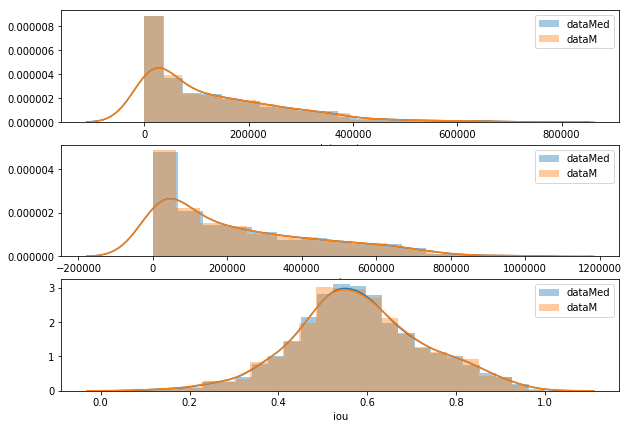

In [500]:
plt.figure(figsize=(10,7))
plt.subplot(311)
sns.distplot(dataMed['intesect'], label='dataMed')
sns.distplot(dataM['intesect'], label='dataM')
plt.legend()

plt.subplot(312)
sns.distplot(dataMed['union'], label='dataMed')
sns.distplot(dataM['union'],  label='dataM')
plt.legend()

plt.subplot(313)
sns.distplot(dataMed['iou'], label='dataMed')
sns.distplot(dataM['iou'],label='dataM')
plt.legend()

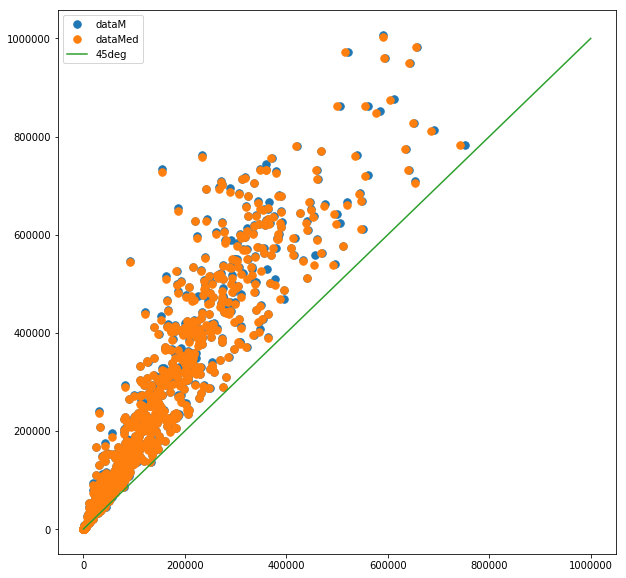

In [501]:
plt.figure(figsize=(10,10))
plt.plot(dataM['intesect'], dataM['union'], '.', label='dataM', markersize=15)
plt.plot(dataMed['intesect'], dataMed['union'], '.', label='dataMed', markersize=15)
plt.plot([0, 1000000], [0, 1000000], label='45deg')
plt.legend()

Выбираем параметры квантилей:

In [491]:
L = []
rmin = np.arange(0,.2,0.1)
rmax = np.arange(.9,1.0,0.03)
for qxmin in rmin:
    for qymin in rmin:
        for qxmax in rmax:
            for qymax in rmax:
                print(qxmin, qymin, qxmax, qymax)
                res_median = predict_by_quantile(data, qxmin, qymin, qxmax, qymax)
                l = local_miou_score(dataMed, res_median)
                L.append((qxmin, qymin, qxmax, qymax, l))
del rmax, rmin, l

0.0 0.0 0.9 0.9
0.0 0.0 0.9 0.93
0.0 0.0 0.9 0.9600000000000001
0.0 0.0 0.9 0.9900000000000001
0.0 0.0 0.93 0.9
0.0 0.0 0.93 0.93
0.0 0.0 0.93 0.9600000000000001
0.0 0.0 0.93 0.9900000000000001
0.0 0.0 0.9600000000000001 0.9
0.0 0.0 0.9600000000000001 0.93
0.0 0.0 0.9600000000000001 0.9600000000000001
0.0 0.0 0.9600000000000001 0.9900000000000001
0.0 0.0 0.9900000000000001 0.9
0.0 0.0 0.9900000000000001 0.93
0.0 0.0 0.9900000000000001 0.9600000000000001
0.0 0.0 0.9900000000000001 0.9900000000000001
0.0 0.1 0.9 0.9
0.0 0.1 0.9 0.93
0.0 0.1 0.9 0.9600000000000001
0.0 0.1 0.9 0.9900000000000001
0.0 0.1 0.93 0.9
0.0 0.1 0.93 0.93
0.0 0.1 0.93 0.9600000000000001
0.0 0.1 0.93 0.9900000000000001
0.0 0.1 0.9600000000000001 0.9
0.0 0.1 0.9600000000000001 0.93
0.0 0.1 0.9600000000000001 0.9600000000000001
0.0 0.1 0.9600000000000001 0.9900000000000001
0.0 0.1 0.9900000000000001 0.9
0.0 0.1 0.9900000000000001 0.93
0.0 0.1 0.9900000000000001 0.9600000000000001
0.0 0.1 0.9900000000000001 0.990000000

In [467]:
L

[(0.0, 0.0, 0.0, 0.0, 0.4041253753149371),
 (0.0, 0.0, 0.0, 0.3, 0.4572343312357635),
 (0.0, 0.0, 0.0, 0.6, 0.47125325184233985),
 (0.0, 0.0, 0.0, 0.8999999999999999, 0.47708755970421013),
 (0.0, 0.0, 0.3, 0.0, 0.4483798518243491),
 (0.0, 0.0, 0.3, 0.3, 0.5246506716471562),
 (0.0, 0.0, 0.3, 0.6, 0.541643523911206),
 (0.0, 0.0, 0.3, 0.8999999999999999, 0.5482355264296918),
 (0.0, 0.0, 0.6, 0.0, 0.46513943361995447),
 (0.0, 0.0, 0.6, 0.3, 0.5453235588130332),
 (0.0, 0.0, 0.6, 0.6, 0.5635428662407711),
 (0.0, 0.0, 0.6, 0.8999999999999999, 0.5701678700402796),
 (0.0, 0.0, 0.8999999999999999, 0.0, 0.47310943175075537),
 (0.0, 0.0, 0.8999999999999999, 0.3, 0.5548043294075631),
 (0.0, 0.0, 0.8999999999999999, 0.6, 0.5733584602505002),
 (0.0, 0.0, 0.8999999999999999, 0.8999999999999999, 0.5798433948204366),
 (0.0, 0.3, 0.0, 0.0, 0.39501885185614327),
 (0.0, 0.3, 0.0, 0.3, 0.44907880393131566),
 (0.0, 0.3, 0.0, 0.6, 0.4633153258409707),
 (0.0, 0.3, 0.0, 0.8999999999999999, 0.4691896308160955),


In [492]:
df2 = pd.DataFrame(L, columns=['qxmin', 'qymin', 'qxmax', 'qymax', 'miou'])
df2

qxmin  qymin  qxmax  qymax      miou
0     0.0    0.0   0.90   0.90  0.579843
1     0.0    0.0   0.90   0.93  0.580243
2     0.0    0.0   0.90   0.96  0.580284
3     0.0    0.0   0.90   0.99  0.580211
4     0.0    0.0   0.93   0.90  0.580241
5     0.0    0.0   0.93   0.93  0.580636
6     0.0    0.0   0.93   0.96  0.580668
7     0.0    0.0   0.93   0.99  0.580589
8     0.0    0.0   0.96   0.90  0.580553
9     0.0    0.0   0.96   0.93  0.580940
10    0.0    0.0   0.96   0.96  0.580961
11    0.0    0.0   0.96   0.99  0.580874
12    0.0    0.0   0.99   0.90  0.580740
13    0.0    0.0   0.99   0.93  0.581118
14    0.0    0.0   0.99   0.96  0.581125
15    0.0    0.0   0.99   0.99  0.581026
16    0.0    0.1   0.90   0.90  0.577579
17    0.0    0.1   0.90   0.93  0.577984
18    0.0    0.1   0.90   0.96  0.578016
19    0.0    0.1   0.90   0.99  0.577932
20    0.0    0.1   0.93   0.90  0.577985
21    0.0    0.1   0.93   0.93  0.578384
22    0.0    0.1   0.93   0.96  0.578408
23    0.0    0.1   0.93   0.99  0.578319
24    0.0    0.1   0.96   0.90  0.578311
25    0.0    0.1   0.96   0.93  0.578702
26    0.0    0.1   0.96   0.96  0.578715
27    0.0    0.1   0.96   0.99  0.578619
28    0.0    0.1   0.99   0.90  0.578523
29    0.0    0.1   0.99   0.93  0.578905
..    ...    ...    ...    ...       ...
34    0.1    0.0   0.90   0.96  0.576344
35    0.1    0.0   0.90   0.99  0.576279
36    0.1    0.0   0.93   0.90  0.576308
37    0.1    0.0   0.93   0.93  0.576702
38    0.1    0.0   0.93   0.96  0.576738
39    0.1    0.0   0.93   0.99  0.576668
40    0.1    0.0   0.96   0.90  0.576633
41    0.1    0.0   0.96   0.93  0.577021
42    0.1    0.0   0.96   0.96  0.577046
43    0.1    0.0   0.96   0.99  0.576968
44    0.1    0.0   0.99   0.90  0.576835
45    0.1    0.0   0.99   0.93  0.577215
46    0.1    0.0   0.99   0.96  0.577227
47    0.1    0.0   0.99   0.99  0.577140
48    0.1    0.1   0.90   0.90  0.573680
49    0.1    0.1   0.90   0.93  0.574080
50    0.1    0.1   0.90   0.96  0.574114
51    0.1    0.1   0.90   0.99  0.574038
52    0.1    0.1   0.93   0.90  0.574094
53    0.1    0.1   0.93   0.93  0.574490
54    0.1    0.1   0.93   0.96  0.574517
55    0.1    0.1   0.93   0.99  0.574436
56    0.1    0.1   0.96   0.90  0.574431
57    0.1    0.1   0.96   0.93  0.574821
58    0.1    0.1   0.96   0.96  0.574838
59    0.1    0.1   0.96   0.99  0.574750
60    0.1    0.1   0.99   0.90  0.574657
61    0.1    0.1   0.99   0.93  0.575039
62    0.1    0.1   0.99   0.96  0.575043
63    0.1    0.1   0.99   0.99  0.574946

[64 rows x 5 columns]

In [493]:
df2.to_csv('quantiles2.csv')

In [494]:
df2.ix[df2['miou'].argmax()]

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


qxmin    0.000000
qymin    0.000000
qxmax    0.990000
qymax    0.960000
miou     0.581125
Name: 14, dtype: float64

###  Тестовые данные

Для всех Юзеров, которых знаем, ставим IoU, а для остальных ставим на правый глаз

In [507]:
test_data = test_votes

Проверяем результат

In [508]:
print(test_data.shape)
test_data.head(20)

(3615, 6)


userId  itemId  Xmin  Ymin  Xmax  Ymax
0     1581   34804    86   640   242   743
1     1351   34804    85   655   273   766
2      161   34804    85   648   268   748
3      313    5704    32   618   647  1268
4     1097    5704    25   620   602  1242
5     1525    5704   118   690   583  1191
6      957   32082    50   437   259   575
7      947   32082    42   414   252   583
8      237   32082    63   424   250   569
9      191   32082    59   483   262   584
10     465   32082    41   426   256   588
11     128   32082    40   433   259   577
12     307   25757   287   286   993   781
13    1508   25757   389   389   803   715
14    1454   25757   382   322   916   789
15     161   18505    33   582    92   640
16     374   18505    35   584    93   639
17    1304   18505    37   599    67   627
18    1033   18505    33   583    91   639
19     312   18505    34   583    91   639

In [509]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем предикт

In [510]:
# res = predict(test_data)
res = predict_by_quantile(test_data, .0,.0,.99,.96)
print(res.shape)
res.head(10)

(630, 5)


itemId   Xmin    Xmax   Ymin     Ymax
0      18  126.0  763.30  634.0  1127.12
1      19   27.0  118.88  559.0   728.84
2      33   21.0  413.02  380.0   650.16
3      62   35.0  638.28  824.0  1261.28
4     114   41.0  215.88  570.0   778.64
5     146   17.0  642.37  211.0  1110.44
6     156   74.0  159.90  802.0   886.36
7     163   21.0  213.00  317.0   465.00
8     164    4.0  399.96  146.0   678.52
9     179  116.0  329.82  490.0   732.84

In [511]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

del res

## МинМин-МаксМакс c фильтрацией Юзеров по mean_user_iou

Достаём знания из Трейновой выборки

In [820]:
data = init_data()
data = data_add_iou(data)

In [821]:
data = data_add_userIoU(data)

print(data.shape)
data.head(20)

(5337, 13)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
1       1399    6132   184   662   235   740         47        650        213   
2425    1399    5778   333   860   589  1114        198        815        581   
4383    1399    5797    86   328   591   874          6        326        541   
2       1694    6132    63   648   272   830         47        650        213   
2429    1694    5778   288   830   585  1206        198        815        581   
3927    1694    1024   104   635   250   798         33        619        226   
4009    1694     576   187   477   515   824         96        467        520   
4384    1694    5797    39   296   690   947          6        326        541   
5008    1694     511    80   782   203   923         55        827        181   
3        916    6132   111   637   253   831         47        650        213   
1047     916    6646    38   535   346   808         16        521        355   
1582     916    6171   124   477   922   941         24        258       1029   
2148     916    6606    75   246   651   611          3        151        717   
2212     916    6665    45   850    80   877         36        843         86   
2431     916    5778   306   816   643  1160        198        815        581   
3762     916    6162   132   832   477  1149         41        775        589   
4       1621    6132    60   651   242   819         47        650        213   

      Ymax_true  mean_user_iou  median_user_iou  sum_user_iou  
0           812       0.469767         0.501507      1.409301  
1580       1226       0.469767         0.501507      1.409301  
2430       1198       0.469767         0.501507      1.409301  
1           812       0.395544         0.423558      1.186631  
2425       1198       0.395544         0.423558      1.186631  
4383        801       0.395544         0.423558      1.186631  
2           812       0.578063         0.570329      3.468375  
2429       1198       0.578063         0.570329      3.468375  
3927        816       0.578063         0.570329      3.468375  
4009        792       0.578063         0.570329      3.468375  
4384        801       0.578063         0.570329      3.468375  
5008        941       0.578063         0.570329      3.468375  
3           812       0.481137         0.489260      3.367958  
1047       1013       0.481137         0.489260      3.367958  
1582       1226       0.481137         0.489260      3.367958  
2148        681       0.481137         0.489260      3.367958  
2212        886       0.481137         0.489260      3.367958  
2431       1198       0.481137         0.489260      3.367958  
3762       1112       0.481137         0.489260      3.367958  
4           812       0.440480         0.479586      2.202400

In [822]:
# def remove_users_by_miou(data, iou_thr):
#     data = data[data['mean_user_iou'] >= iou_thr]


#  Удаляем юзеров, у которых mean_user_iou < iou_thr. 
# При этом оставляем картинки, у которых других оценок кроме этого пользователя нет.
# 
def remove_users_by_miou(data, col, iou_thr):
    for it in data['itemId'].unique():
        tmp = data[data['itemId'] == it]

#         print(it, tmp.shape)
        if tmp.shape[0] > 1:
#             print('> ', it, data.shape, end='')

            selected = data[ (data['itemId'] == it) & (data[col] < iou_thr) ]['userId'].values
    #         print(selected)
            selected = data[data['userId'].isin(selected)].index
    #         print(selected)
            data.drop(selected, inplace=True)

#             print(data.shape)
    return data

In [823]:
# def predict(votes):
#     quorum_min = votes.groupby("itemId")[['Xmin','Ymin']].min().reset_index()
#     quorum_max = votes.groupby("itemId")[['Xmax', 'Ymax']].max().reset_index()
#     res = quorum_min.merge(quorum_max, on=['itemId'])
#     return res

Считаем результат на трейне

In [824]:
data_filt = remove_users_by_miou(data, 'mean_user_iou', .3)
print(data_filt.shape)
data_filt.head()

(4759, 13)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
1       1399    6132   184   662   235   740         47        650        213   
2425    1399    5778   333   860   589  1114        198        815        581   

      Ymax_true  mean_user_iou  median_user_iou  sum_user_iou  
0           812       0.469767         0.501507      1.409301  
1580       1226       0.469767         0.501507      1.409301  
2430       1198       0.469767         0.501507      1.409301  
1           812       0.395544         0.423558      1.186631  
2425       1198       0.395544         0.423558      1.186631

Проверяем на Трейне

In [825]:
res = predictByMinMax(data_filt)

local_miou_score(res)

0.5812187451286294

Ищем хороший порог

In [544]:
for thr in np.arange(0, 1.0, 0.1):
    data_filt = remove_users_by_miou(data, 'mean_user_iou', thr)
    res = predict(data_filt)

    print(thr, local_miou_score(data_filt, res))

0.0 0.5810540921851994
0.1 0.5810540921851994
0.2 0.5810540921851994
0.30000000000000004 0.5810540921851994
0.4 0.5787444711314788
0.5 0.5796953335387994
0.6000000000000001 0.6159017966257632
0.7000000000000001 0.6189796880287718
0.8 0.6187299702633245
0.9 0.6154721170774361


###  Тестовые данные

Для всех Юзеров, которых знаем, ставим IoU, а для остальных ставим на правый глаз

In [417]:
test_data = test_votes.merge(right=data[['userId', 'mean_user_iou']], how='left', on='userId')
test_data.drop_duplicates(inplace=True)
test_data.reset_index(inplace=True, drop=True);

In [418]:
test_data.fillna(value=.9, inplace=True)

Проверяем результат

In [420]:
print(test_data.shape)
print(sum(pd.Series(test_data['mean_user_iou'].notna())))
test_data.head(20)

(3615, 7)
3615


userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou
0     1581   34804    86   640   242   743        0.90000
1     1351   34804    85   655   273   766        0.90000
2      161   34804    85   648   268   748        0.90000
3      313    5704    32   618   647  1268        0.90000
4     1097    5704    25   620   602  1242        0.90000
5     1525    5704   118   690   583  1191        0.55102
6      957   32082    50   437   259   575        0.90000
7      947   32082    42   414   252   583        0.90000
8      237   32082    63   424   250   569        0.90000
9      191   32082    59   483   262   584        0.90000
10     465   32082    41   426   256   588        0.90000
11     128   32082    40   433   259   577        0.90000
12     307   25757   287   286   993   781        0.90000
13    1508   25757   389   389   803   715        0.90000
14    1454   25757   382   322   916   789        0.90000
15     161   18505    33   582    92   640        0.90000
16     374   18505    35   584    93   639        0.90000
17    1304   18505    37   599    67   627        0.90000
18    1033   18505    33   583    91   639        0.90000
19     312   18505    34   583    91   639        0.90000

In [421]:
test_structure(test_data)

(630,)
(630,)
All good


Отсеиваем плохих ЮЕЗРОВ по IoU

In [422]:
test_data = remove_users_by_miou(test_data, .6)

In [423]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем МинМин-МаксМакс

In [424]:
res = predict(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [425]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

In [440]:
del res

## МинМин-МаксМакс c фильтрацией Юзеров по sum_user_iou

Достаём знания из Трейновой выборки

In [445]:
data = init_data()
data = data_add_iou(data)

In [446]:
data = data_add_userIoU(data)

print(data.shape)
data.head(20)

(5337, 13)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
0       1164    6132    62   656   276   803         47        650        213   
1580    1164    6171   123   451   843   848         24        258       1029   
2430    1164    5778   304   856   615  1139        198        815        581   
1       1399    6132   184   662   235   740         47        650        213   
2425    1399    5778   333   860   589  1114        198        815        581   
4383    1399    5797    86   328   591   874          6        326        541   
2       1694    6132    63   648   272   830         47        650        213   
2429    1694    5778   288   830   585  1206        198        815        581   
3927    1694    1024   104   635   250   798         33        619        226   
4009    1694     576   187   477   515   824         96        467        520   
4384    1694    5797    39   296   690   947          6        326        541   
5008    1694     511    80   782   203   923         55        827        181   
3        916    6132   111   637   253   831         47        650        213   
1047     916    6646    38   535   346   808         16        521        355   
1582     916    6171   124   477   922   941         24        258       1029   
2148     916    6606    75   246   651   611          3        151        717   
2212     916    6665    45   850    80   877         36        843         86   
2431     916    5778   306   816   643  1160        198        815        581   
3762     916    6162   132   832   477  1149         41        775        589   
4       1621    6132    60   651   242   819         47        650        213   

      Ymax_true       iou  mean_user_iou  sum_user_iou  
0           812  0.613974       0.469767      1.409301  
1580       1226  0.293820       0.469767      1.409301  
2430       1198  0.501507       0.469767      1.409301  
1           812  0.079069       0.395544      1.186631  
2425       1198  0.423558       0.395544      1.186631  
4383        801  0.684004       0.395544      1.186631  
2           812  0.598080       0.578063      3.468375  
2429       1198  0.716262       0.578063      3.468375  
3927        816  0.474233       0.578063      3.468375  
4009        792  0.696715       0.578063      3.468375  
4384        801  0.542578       0.578063      3.468375  
5008        941  0.440507       0.578063      3.468375  
3           812  0.435805       0.481137      3.367958  
1047       1013  0.504137       0.481137      3.367958  
1582       1226  0.380609       0.481137      3.367958  
2148        681  0.555573       0.481137      3.367958  
2212        886  0.439535       0.481137      3.367958  
2431       1198  0.563038       0.481137      3.367958  
3762       1112  0.489260       0.481137      3.367958  
4           812  0.750206       0.440480      2.202400

Считаем результат на трейне

In [450]:
data_filt = remove_users_by_miou(data, 'sum_user_iou', 3)
print(data_filt.shape)
data_filt.head()

(2454, 13)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2       1694    6132    63   648   272   830         47        650        213   
2429    1694    5778   288   830   585  1206        198        815        581   
3927    1694    1024   104   635   250   798         33        619        226   
4009    1694     576   187   477   515   824         96        467        520   
4384    1694    5797    39   296   690   947          6        326        541   

      Ymax_true       iou  mean_user_iou  sum_user_iou  
2           812  0.598080       0.578063      3.468375  
2429       1198  0.716262       0.578063      3.468375  
3927        816  0.474233       0.578063      3.468375  
4009        792  0.696715       0.578063      3.468375  
4384        801  0.542578       0.578063      3.468375

Проверяем на Трейне

In [451]:
res = predict(data_filt)

local_miou_score(data_filt, res)

0.5514573436333633

Ищем хороший порог

In [452]:
for thr in np.arange(0, 25.0, 0.5):
    data_filt = remove_users_by_miou(data, 'sum_user_iou', thr)
    res = predict(data_filt)

    print(thr, local_miou_score(data_filt, res))

0.0 0.5514573436333633
0.5 0.5514573436333633
1.0 0.5514573436333633
1.5 0.5514573436333633
2.0 0.5514573436333633
2.5 0.5514573436333633
3.0 0.5514573436333633
3.5 0.5453731061551702
4.0 0.5415579569167249
4.5 0.5347268986919874
5.0 0.5320106168860528
5.5 0.5269339410889378
6.0 0.5214317652453114
6.5 0.5202290654559895
7.0 0.5168047161509779
7.5 0.5126484449194525
8.0 0.5060652580193863
8.5 0.505624891984773
9.0 0.49936658322004296
9.5 0.49762379575101945
10.0 0.4966465290741571
10.5 0.494954361074238
11.0 0.49297348253539797
11.5 0.4842993826311716
12.0 0.47969901972761064
12.5 0.47735558046791693
13.0 0.47735558046791693
13.5 0.47735558046791693
14.0 0.4783481270224564
14.5 0.4783481270224564
15.0 0.4783481270224564
15.5 0.4776828879146286
16.0 0.46692255793999254
16.5 0.46692255793999254
17.0 0.4585308407926917
17.5 0.45749335562857346
18.0 0.45749335562857346
18.5 0.48445464210447253
19.0 0.48445464210447253
19.5 0.48445464210447253
20.0 0.48445464210447253
20.5 0.4844546421044725

###  Тестовые данные

Для всех Юзеров, которых знаем, ставим IoU, а для остальных ставим на правый глаз

In [468]:
test_data = test_votes.merge(right=data[['userId', 'mean_user_iou', 'sum_user_iou']], how='left', on='userId')
test_data.drop_duplicates(inplace=True)
test_data.reset_index(inplace=True, drop=True);

In [469]:
test_data['sum_user_iou'].fillna(value=24, inplace=True)
test_data['mean_user_iou'].fillna(value=.9, inplace=True)

Проверяем результат

In [470]:
print(test_data.shape)
print(sum(pd.Series(test_data['mean_user_iou'].notna())))
test_data.head(20)

(3615, 8)
3615


userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou
0     1581   34804    86   640   242   743       0.900000     24.000000
1     1351   34804    85   655   273   766       0.900000     24.000000
2      161   34804    85   648   268   748       0.900000     24.000000
3      313    5704    32   618   647  1268       0.900000     24.000000
4     1097    5704    25   620   602  1242       0.900000     24.000000
5     1525    5704   118   690   583  1191       0.900000     24.000000
6      957   32082    50   437   259   575       0.900000     24.000000
7      947   32082    42   414   252   583       0.900000     24.000000
8      237   32082    63   424   250   569       0.900000     24.000000
9      191   32082    59   483   262   584       0.900000     24.000000
10     465   32082    41   426   256   588       0.900000     24.000000
11     128   32082    40   433   259   577       0.900000     24.000000
12     307   25757   287   286   993   781       0.900000     24.000000
13    1508   25757   389   389   803   715       0.378287     29.884709
14    1454   25757   382   322   916   789       0.900000     24.000000
15     161   18505    33   582    92   640       0.900000     24.000000
16     374   18505    35   584    93   639       0.900000     24.000000
17    1304   18505    37   599    67   627       0.900000     24.000000
18    1033   18505    33   583    91   639       0.900000     24.000000
19     312   18505    34   583    91   639       0.900000     24.000000

In [471]:
test_structure(test_data)

(630,)
(630,)
All good


Отсеиваем плохих ЮЕЗРОВ по IoU

In [472]:
test_data = remove_users_by_miou(test_data, 'sum_user_iou', 7)

In [473]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем МинМин-МаксМакс

In [474]:
res = predict(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [475]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

In [476]:
del res

## МинМин-МаксМакс c коррекцией оценок юзеров

Достаём знания из Трейновой выборки

In [62]:
data = init_data()
data = data_add_iou(data)
data = data_add_userIoU(data)
data = data_add_xy_err(data)
data = data_add_median_err(data)

In [63]:
print(data.shape)
data.sort_values('itemId').head(20)

(5337, 22)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2990    1723       5   192   914   510  1331        198        827        649   
2988     141       5   210   925   483  1255        198        827        649   
2989     903       5   151   917   511  1160        198        827        649   
3766     141      10    95   559   427   852         26        605        433   
3765    1723      10    96   559   402   856         26        605        433   
3764     903      10    72   570   420   858         26        605        433   
3363     141      13    46   600   621   969        233        698        622   
3362    1723      13    69   606   561   981        233        698        622   
3361     903      13    94   603   608   950        233        698        622   
2959    1508      30    85   359   323   491         61        368        329   
2960     903      30    87   353   316   491         61        368        329   
2957    1573      30   124   374   286   468         61        368        329   
2958    1565      30    65   375   324   477         61        368        329   
2956     141      30    96   367    97   369         61        368        329   
1727     366      32    39   809   128   884         30        536        328   
1724     366      32     9   321   387   638         30        536        328   
1725     903      32    17   319   380   631         30        536        328   
1728     903      32    41   809   126   883         30        536        328   
1723     141      32    21   279   388   624         30        536        328   
1726     141      32    42   799   128   881         30        536        328   

      Ymax_true      ...       median_user_iou  sum_user_iou  Xmin_err  \
2990       1340      ...              0.456958      2.480096         6   
2988       1340      ...              0.405542      3.467387       -12   
2989       1340      ...              0.489660     11.107477        47   
3766        847      ...              0.405542      3.467387       -69   
3765        847      ...              0.456958      2.480096       -70   
3764        847      ...              0.489660     11.107477       -46   
3363        920      ...              0.405542      3.467387       187   
3362        920      ...              0.456958      2.480096       164   
3361        920      ...              0.489660     11.107477       139   
2959        530      ...              0.381162     29.884709       -24   
2960        530      ...              0.489660     11.107477       -26   
2957        530      ...              0.350746      3.437293       -63   
2958        530      ...              0.494459      4.952860        -4   
2956        530      ...              0.405542      3.467387       -35   
1727        813      ...              0.604596      2.878160        -9   
1724        813      ...              0.604596      2.878160        21   
1725        813      ...              0.489660     11.107477        13   
1728        813      ...              0.489660     11.107477       -11   
1723        813      ...              0.405542      3.467387         9   
1726        813      ...              0.405542      3.467387       -12   

      Ymin_err  Xmax_err  Ymax_err  Xmin_med_err  Ymin_med_err  Xmax_med_err  \
2990       -87       139         9           6.0         -90.0         139.0   
2988       -98       166        85           6.0         -90.0         139.0   
2989       -90       138       180           6.0         -90.0         139.0   
3766        46         6        -5         -69.0          46.0          13.0   
3765        46        31        -9         -69.0          46.0          13.0   
3764        35        13       -11         -69.0          46.0          13.0   
3363        98         1       -49         164.0          95.0          14.0   
3362        92        61       -61         164.0          95.0          14.0   
3361        95        14     

Считаем результат на трейне

In [64]:
data_filt = remove_users_by_miou(data, 'sum_user_iou', 3)
print(data_filt.shape)
data_filt.head()

(2454, 22)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2       1694    6132    63   648   272   830         47        650        213   
3        916    6132   111   637   253   831         47        650        213   
5       1092    6132    39   649   249   825         47        650        213   
1582     916    6171   124   477   922   941         24        258       1029   
1577    1092    6171    87   371   931   965         24        258       1029   

      Ymax_true      ...       median_user_iou  sum_user_iou  Xmin_err  \
2           812      ...              0.570329      3.468375       -16   
3           812      ...              0.489260      3.367958       -64   
5           812      ...              0.490322      3.016915         8   
1582       1226      ...              0.489260      3.367958      -100   
1577       1226      ...              0.490322      3.016915       -63   

      Ymin_err  Xmax_err  Ymax_err  Xmin_med_err  Ymin_med_err  Xmax_med_err  \
2            2       -59       -18         -15.5           0.0         -38.0   
3           13       -40       -19         -15.5           0.0         -38.0   
5            1       -36       -13         -15.5           0.0         -38.0   
1582      -219       107       285        -100.0        -193.0         143.0   
1577      -113        98       261        -100.0        -193.0         143.0   

      Ymax_med_err  
2            -10.0  
3            -10.0  
5            -10.0  
1582         285.0  
1577         285.0  

[5 rows x 22 columns]

Проверяем на Трейне

In [65]:
res = predict(data_filt)

local_miou_score(data_filt, res)

0.5514573436333633

Ищем хороший порог

In [452]:
for thr in np.arange(0, 25.0, 0.5):
    data_filt = remove_users_by_miou(data, 'sum_user_iou', thr)
    res = predict(data_filt)

    print(thr, local_miou_score(data_filt, res))

0.0 0.5514573436333633
0.5 0.5514573436333633
1.0 0.5514573436333633
1.5 0.5514573436333633
2.0 0.5514573436333633
2.5 0.5514573436333633
3.0 0.5514573436333633
3.5 0.5453731061551702
4.0 0.5415579569167249
4.5 0.5347268986919874
5.0 0.5320106168860528
5.5 0.5269339410889378
6.0 0.5214317652453114
6.5 0.5202290654559895
7.0 0.5168047161509779
7.5 0.5126484449194525
8.0 0.5060652580193863
8.5 0.505624891984773
9.0 0.49936658322004296
9.5 0.49762379575101945
10.0 0.4966465290741571
10.5 0.494954361074238
11.0 0.49297348253539797
11.5 0.4842993826311716
12.0 0.47969901972761064
12.5 0.47735558046791693
13.0 0.47735558046791693
13.5 0.47735558046791693
14.0 0.4783481270224564
14.5 0.4783481270224564
15.0 0.4783481270224564
15.5 0.4776828879146286
16.0 0.46692255793999254
16.5 0.46692255793999254
17.0 0.4585308407926917
17.5 0.45749335562857346
18.0 0.45749335562857346
18.5 0.48445464210447253
19.0 0.48445464210447253
19.5 0.48445464210447253
20.0 0.48445464210447253
20.5 0.4844546421044725

###  Тестовые данные

Для всех Юзеров, которых знаем, ставим IoU, а для остальных ставим на правый глаз

In [468]:
test_data = test_votes.merge(right=data[['userId', 'mean_user_iou', 'sum_user_iou']], how='left', on='userId')
test_data.drop_duplicates(inplace=True)
test_data.reset_index(inplace=True, drop=True);

In [469]:
test_data['sum_user_iou'].fillna(value=24, inplace=True)
test_data['mean_user_iou'].fillna(value=.9, inplace=True)

Проверяем результат

In [470]:
print(test_data.shape)
print(sum(pd.Series(test_data['mean_user_iou'].notna())))
test_data.head(20)

(3615, 8)
3615


userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou
0     1581   34804    86   640   242   743       0.900000     24.000000
1     1351   34804    85   655   273   766       0.900000     24.000000
2      161   34804    85   648   268   748       0.900000     24.000000
3      313    5704    32   618   647  1268       0.900000     24.000000
4     1097    5704    25   620   602  1242       0.900000     24.000000
5     1525    5704   118   690   583  1191       0.900000     24.000000
6      957   32082    50   437   259   575       0.900000     24.000000
7      947   32082    42   414   252   583       0.900000     24.000000
8      237   32082    63   424   250   569       0.900000     24.000000
9      191   32082    59   483   262   584       0.900000     24.000000
10     465   32082    41   426   256   588       0.900000     24.000000
11     128   32082    40   433   259   577       0.900000     24.000000
12     307   25757   287   286   993   781       0.900000     24.000000
13    1508   25757   389   389   803   715       0.378287     29.884709
14    1454   25757   382   322   916   789       0.900000     24.000000
15     161   18505    33   582    92   640       0.900000     24.000000
16     374   18505    35   584    93   639       0.900000     24.000000
17    1304   18505    37   599    67   627       0.900000     24.000000
18    1033   18505    33   583    91   639       0.900000     24.000000
19     312   18505    34   583    91   639       0.900000     24.000000

In [471]:
test_structure(test_data)

(630,)
(630,)
All good


Отсеиваем плохих ЮЕЗРОВ по IoU

In [472]:
test_data = remove_users_by_miou(test_data, 'sum_user_iou', 7)

In [473]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем МинМин-МаксМакс

In [474]:
res = predict(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [475]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

In [476]:
del res

## Предиктор по IOU

Достаём знания из Трейновой выборки

In [38]:
data = init_data()
# data = data_add_iou(data)
data = data_add_userIoU(data)
data = data_add_area(data)
# data = data_add_median_err(data)

print(data.shape)
data.sort_values('itemId').head(10)

(5337, 15)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2990    1723       5   192   914   510  1331        198        827        649   
2989     903       5   151   917   511  1160        198        827        649   
2988     141       5   210   925   483  1255        198        827        649   
3765    1723      10    96   559   402   856         26        605        433   
3766     141      10    95   559   427   852         26        605        433   
3764     903      10    72   570   420   858         26        605        433   
3362    1723      13    69   606   561   981        233        698        622   
3363     141      13    46   600   621   969        233        698        622   
3361     903      13    94   603   608   950        233        698        622   
2958    1565      30    65   375   324   477         61        368        329   

      Ymax_true  mean_user_iou  median_user_iou  sum_user_iou    area  \
2990       1340       0.413349         0.456958      2.480096  132606   
2989       1340       0.482934         0.489660     11.107477   87480   
2988       1340       0.385265         0.405542      3.467387   90090   
3765        847       0.413349         0.456958      2.480096   90882   
3766        847       0.385265         0.405542      3.467387   97276   
3764        847       0.482934         0.489660     11.107477  100224   
3362        920       0.413349         0.456958      2.480096  184500   
3363        920       0.385265         0.405542      3.467387  212175   
3361        920       0.482934         0.489660     11.107477  178358   
2958        530       0.550318         0.494459      4.952860   26418   

      area_true  
2990     231363  
2989     231363  
2988     231363  
3765      98494  
3766      98494  
3764      98494  
3362      86358  
3363      86358  
3361      86358  
2958      43416

In [52]:
col_drop = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'area_true']
col_pred = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']

X = data.drop(col_drop, axis=1)
Y = data[col_pred]

print(X.columns)
print(Y.columns)

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=42)
print(X_train.columns)
print(X_test.columns)
print(y_train.columns)
print(y_test.columns)

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')
Index(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')


In [79]:
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50] }
# predictor = DecisionTreeRegressor()

# param_grid = {'max_depth': [5, 25, 50, 100],
#              'n_estimators': [10, 50, 100]}
# predictor = RandomForestRegressor()

# param_grid = {'alpha_1': np.linspace(1.e-6, 2, 10 ),
#               'alpha_2': np.linspace(1.e-6, 2, 10 ),
#               'lambda_1': np.linspace(1.e-6, 2, 10 ),
#               'lambda_2': np.linspace(1.e-6, 2, 10 ),}
# predictor = MultiOutputRegressor(BayesianRidge())

param_grid = {'estimator__max_depth': [20, 22, 25, 26, 30, 35],
              'estimator__n_estimators': [100, 200, 300, 400],
             }
predictor = MultiOutputRegressor(lgb.LGBMRegressor(objective = 'regression'))


predictor = model_selection.GridSearchCV(predictor, param_grid=param_grid, 
                                 cv=3, scoring=iou_scorer, verbose=1, n_jobs=-1)
#                             cv=10, scoring='r2', verbose=1, n_jobs=-1)

predictor.fit(X_train, y_train)
predictor = predictor.best_estimator_

print(predictor)
print(predictor.score(X_train, y_train))
print(predictor.score(X_test, y_test))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   43.5s finished


MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=25,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
           n_jobs=None)
0.9800413516573371
0.8050650742312717


**DecisionTreeRegressor**
0.8738306238977888 train
0.8127524053159632 test
0.41322624384066703 iou 

**RandomForestRegressor**
0.5507185523953101 iou
max_depth=50, n_estimators=200
0.5521861713279739 iou


**Обучение с метрикой IoU**
DecisionTreeRegressor
cv=10
0.10358313181949036 train
0.25482991570998736 test

cv=5
0.5726427386206598
0.5683302128064197

RandomForestRegressor
cv=3
0.85869061117192
0.8509310802049544

**Обучение с метрикой IoU и ММММ и группировкой**
test_size.5
0.9842408539565888
0.8989325620615191

test_size.3
0.9863738893009122
0.9072163028055649

*LGBMRegressor*
max_depth = 25, n_estimators=200
0.9643029753849379
0.7997044494136492

max_depth=25, n_estimators=300
0.9800413516573371
0.8050650742312717


In [80]:
title = 'LC'
plot_learning_curve(predictor, title, X, Y, (0.71, 1.01), cv=7, n_jobs=-1, train_sizes=np.linspace(.1,1,10))

plt.show()

In [81]:
predictor.fit(X, Y)

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=25,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
           n_jobs=None)

In [82]:
# проверяем, что код проверки IoU  верный
temp = y_train
temp['itemId'] = X_train['itemId'].values
temp.columns = ['Xmin', 'Ymin', 'Xmax', 'Ymax', 'itemId']

print(local_miou_score(temp))
temp.head()


/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.9981258366800535


Xmin  Ymin  Xmax  Ymax  itemId
443     25   468  1015  1455   17580
3409    57   608   436   974    1125
3426   111   866   584  1540   32988
4173    82  1055   497  1663    3811
2641    55   565   120   622   31018

### Анализ предиктов

без полного ФИТа, смотрим на тестовую часть

In [83]:
predicted = predictor.predict(X_test)
predicted = pd.DataFrame(predicted, columns=['Xmin','Ymin', 'Xmax', 'Ymax'])
predicted = pd.concat([predicted, y_test.reset_index()], axis=1)  # ДОбавляем true X,Y
predicted['X_test'] = 2
predicted.head()

Xmin         Ymin        Xmax         Ymax  index  Xmin_true  \
0   89.825644   903.082581  235.190082  1067.914280   1468         90   
1   47.910959   571.920831  333.548715   814.708468    287         47   
2   59.355247   990.119233  231.309639  1123.571009   5259         49   
3   48.866306  1147.777548  125.306746  1195.170046   4286         54   
4  225.553901   671.361945  777.586814  1193.108436   2057        236   

   Ymin_true  Xmax_true  Ymax_true  X_test  
0        912        232       1038       2  
1        578        340        809       2  
2        981        235       1118       2  
3       1147        124       1183       2  
4        665        811       1176       2

In [84]:
predNtest = X_test[['Xmin', 'Xmax', 'Ymin', 'Ymax']]
# predNtest = pd.concat([predNtest, y_test.reset_index()], axis=1)  # ДОбавляем true X,Y
predNtest = predNtest.merge(y_test, left_index=True, right_index=True, how='outer')
predNtest['X_test'] = 1
print(predNtest.shape)
predNtest.head()


(1602, 9)


Xmin  Xmax  Ymin  Ymax  Xmin_true  Ymin_true  Xmax_true  Ymax_true  \
1468    66   211   935  1074         90        912        232       1038   
287    128   404   518   801         47        578        340        809   
5259    68   217   992  1162         49        981        235       1118   
4286   101   131  1146  1179         54       1147        124       1183   
2057   487   690   827  1071        236        665        811       1176   

      X_test  
1468       1  
287        1  
5259       1  
4286       1  
2057       1

In [85]:
predNtest = pd.concat([predicted, predNtest])
predNtest.drop('index', inplace=True, axis=1)
print(predNtest.shape)
print(predicted.shape)
predNtest.head()

(3204, 9)
(1602, 10)


/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


X_test        Xmax  Xmax_true        Xmin  Xmin_true         Ymax  \
0       2  235.190082        232   89.825644         90  1067.914280   
1       2  333.548715        340   47.910959         47   814.708468   
2       2  231.309639        235   59.355247         49  1123.571009   
3       2  125.306746        124   48.866306         54  1195.170046   
4       2  777.586814        811  225.553901        236  1193.108436   

   Ymax_true         Ymin  Ymin_true  
0       1038   903.082581        912  
1        809   571.920831        578  
2       1118   990.119233        981  
3       1183  1147.777548       1147  
4       1176   671.361945        665

In [86]:
sns.pairplot(predNtest, hue="X_test", palette="husl")

/home/ivan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ivan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ivan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ivan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


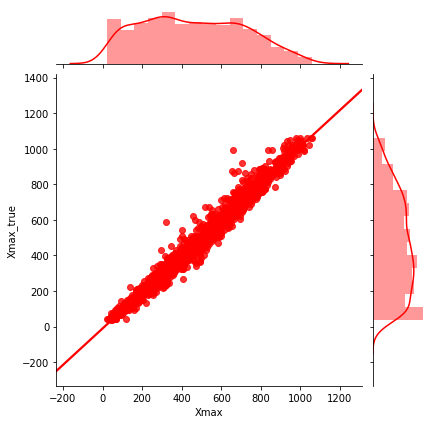

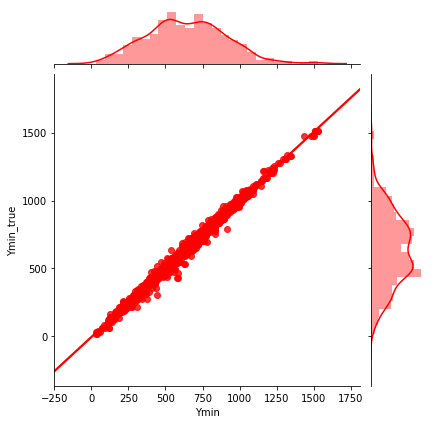

In [87]:
sns.jointplot("Xmin", "Xmin_true", data=predNtest[predNtest["X_test"]==2], kind="reg", color="r")
sns.jointplot("Xmax", "Xmax_true", data=predNtest[predNtest["X_test"]==2], kind="reg", color="r")
sns.jointplot("Ymin", "Ymin_true", data=predNtest[predNtest["X_test"]==2], kind="reg", color="r")
sns.jointplot("Ymax", "Ymax_true", data=predNtest[predNtest["X_test"]==2], kind="reg", color="r")

# sns.jointplot("Xmin", "Xmin_true", data=predicted, kind="reg", )
# sns.jointplot("Xmax", "Xmax_true", data=predicted, kind="reg", )
# sns.jointplot("Ymin", "Ymin_true", data=predicted, kind="reg", )
# sns.jointplot("Ymax", "Ymax_true", data=predicted, kind="reg", )

# sns.jointplot("Xmin", "Xmin_true", data=data, kind="reg")
# sns.jointplot("Xmax", "Xmax_true", data=data, kind="reg")
# sns.jointplot("Ymin", "Ymin_true", data=data, kind="reg")
# sns.jointplot("Ymax", "Ymax_true", data=data, kind="reg")

###  Тестовые данные

In [88]:
test_votes = init_test_data()
print(test_votes.columns)
print(test_votes.shape)
test_votes.head()

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], dtype='object')
(3615, 6)


userId  itemId  Xmin  Ymin  Xmax  Ymax
0    1581   34804    86   640   242   743
1    1351   34804    85   655   273   766
2     161   34804    85   648   268   748
3     313    5704    32   618   647  1268
4    1097    5704    25   620   602  1242

In [89]:
test_data = test_votes.merge(right=data[['userId', \
                'mean_user_iou', 'sum_user_iou', 'median_user_iou']], how='left', on='userId')

test_data = data_add_area(test_data)

test_data.drop_duplicates(inplace=True)
test_data.reset_index(inplace=True, drop=True);

print(test_data.columns)

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'sum_user_iou', 'median_user_iou', 'area'],
      dtype='object')


In [90]:
# NaN-ы  заполняем медианными значениями
# 
test_data['sum_user_iou'].fillna(value=test_data['sum_user_iou'].median(), inplace=True)
test_data['mean_user_iou'].fillna(value=test_data['mean_user_iou'].median(), inplace=True)
test_data['median_user_iou'].fillna(value=test_data['median_user_iou'].median(), inplace=True)


Проверяем структуру

In [91]:
print(test_data.shape)
print(sum(pd.Series(test_data['mean_user_iou'].notna())))
test_data.head(20)

(3615, 10)
3615


userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou  \
0     1581   34804    86   640   242   743       0.475942      1.903770   
1     1351   34804    85   655   273   766       0.475073      5.225801   
2      161   34804    85   648   268   748       0.495931     16.861646   
3      313    5704    32   618   647  1268       0.529712      2.648560   
4     1097    5704    25   620   602  1242       0.537014      9.666254   
5     1525    5704   118   690   583  1191       0.551020      1.102039   
6      957   32082    50   437   259   575       0.465749     18.164228   
7      947   32082    42   414   252   583       0.463139      8.799637   
8      237   32082    63   424   250   569       0.488976      1.466929   
9      191   32082    59   483   262   584       0.318399      8.596778   
10     465   32082    41   426   256   588       0.336250      1.681248   
11     128   32082    40   433   259   577       0.533770      8.540315   
12     307   25757   287   286   993   781       0.471088      2.425149   
13    1508   25757   389   389   803   715       0.378287     29.884709   
14    1454   25757   382   322   916   789       0.484341      3.390385   
15     161   18505    33   582    92   640       0.495931     16.861646   
16     374   18505    35   584    93   639       0.328688      0.986063   
17    1304   18505    37   599    67   627       0.362476      2.899808   
18    1033   18505    33   583    91   639       0.430193      1.290578   
19     312   18505    34   583    91   639       0.471088      2.425149   

    median_user_iou    area  
0          0.493215   16068  
1          0.537190   20868  
2          0.484469   18300  
3          0.442870  399750  
4          0.528277  358894  
5          0.551020  232965  
6          0.465030   28842  
7          0.467723   35490  
8          0.417994   27115  
9          0.322420   20503  
10         0.375470   34830  
11         0.496970   31536  
12         0.477304  349470  
13         0.381162  134964  
14         0.474203  249378  
15         0.484469    3422  
16         0.419053    3190  
17         0.394945     840  
18         0.507234    3248  
19         0.477304    3192

In [92]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем прогноз

In [93]:
predicted = predictor.predict(test_data)

predicted = pd.DataFrame(predicted, columns=['Xmin','Ymin', 'Xmax', 'Ymax'])
predicted['itemId'] = test_data['itemId'].values
predicted

Xmin         Ymin        Xmax         Ymax  itemId
0      38.958889   583.838338  289.788153   760.977431   34804
1      39.471450   613.004703  322.129610   809.616682   34804
2      41.792134   582.833793  316.410637   787.603766   34804
3     105.807714   678.363586  760.796621  1155.756245    5704
4     103.656927   649.118769  681.335649  1227.960184    5704
5     116.617444   699.649511  618.447147  1115.462612    5704
6      36.055570   411.669247  310.993078   590.621078   32082
7      39.607395   370.551662  291.401670   582.268888   32082
8      51.031583   424.019669  300.632003   593.228913   32082
9      38.642848   448.742563  299.112551   647.227611   32082
10     43.126666   391.235167  310.681742   610.643012   32082
11     39.308427   416.709426  295.719203   597.532266   32082
12    122.792729   244.452076  923.752004   853.245559   25757
13    169.368017   296.503651  824.522640   847.502671   25757
14    102.145653   275.120332  893.789797   885.638446   25757
15     41.050977   572.842679  105.595553   646.866038   18505
16     31.524657   578.912130   92.167303   659.658332   18505
17     32.725220   582.214993   76.431422   643.126933   18505
18     27.811911   565.890533  105.925308   662.461988   18505
19     31.198726   572.049849   95.075277   662.373281   18505
20     34.503681   576.540877   96.161205   653.734527   18505
21     87.682241   742.516541  358.323686   999.927302    7318
22     71.066079   705.428821  425.004736  1001.791253    7318
23     95.355416   717.012009  394.875187  1015.483676    7318
24     70.732159   302.460711  624.627613   597.643847    4673
25     53.802251   248.137371  698.557173   754.685356    4673
26     85.507025   238.674869  734.610240   733.865128    4673
27     55.605800   228.393126  654.300390   707.925324    4673
28     64.418748   278.867535  675.783608   755.879902    4673
29    258.468799   622.579214  681.788509  1090.242105   21769
...          ...          ...         ...          ...     ...
3585   45.147244  1338.726213   64.899042  1442.702093   29284
3586   40.292648   416.778898  334.552022   683.756204    5747
3587   74.267531   408.828557  341.648856   698.785622    5747
3588   47.290467   422.378928  394.026990   660.307481    5747
3589   56.194672   499.789634  386.345946   738.437327    5747
3590   87.095110   428.829816  383.321757   708.372233    5747
3591   71.039497   458.780612  447.842724   762.583977    5747
3592   60.868531   415.125561  421.845270   722.774369    5747
3593  111.118807   466.787996  760.728179   828.438769   30935
3594  126.478453   535.152555  621.069831   849.527043   30935
3595  108.678033   515.384386  591.476766   828.884181   30935
3596   81.293066   523.499326  676.100756   843.216025   30935
3597  140.093857   534.252820  658.408193   830.549445   30935
3598   53.977309   795.596279  267.668823   973.362993     432
3599   60.121888   831.929533  342.398267  1037.970133     432
3600   65.249136   845.950571  314.103856  1012.989656     432
3601   40.571548   617.507831  134.339255   695.134198   32282
3602   38.141433   615.513764  143.802650   692.801428   32282
3603   28.463293   624.223990  116.925353   709.493230   32282
3604   48.458045   855.285117  494.663620  1131.668212   13921
3605   56.870363   807.841411  565.009268  1108.927124   13921
3606   55.261459   787.360878  603.758920  1181.959641   13921
3607   41.498188   391.680047   87.580271   480.386467    8358
3608   41.238449   394.837242   82.939044   471.390054    8358
3609   38.444855   387.171851   90.398973   479.516665    8358
3610   41.506616   411.240288   72.132050   459.215392    8358
3611   35.785060   392.564666   98.484066   456.350276    8358
3612  182.735502   388.533389  849.822717   996.411353   33300
3613  177.336811   448.428718  929.077839  1082.304203   33300
3614  200.047818   461.565006  886.205932   959.831671   33300

[3615 rows x 5 columns]

In [71]:
predicted.groupby("itemId")[['Xmin']].count()

Xmin
itemId      
18         2
19         3
33         3
62         7
114        3
146        8
156        3
163        6
164        3
179        3
186        7
215        3
225        8
227        5
247        8
275        7
311       10
399        6
421        6
432        3
442        3
459        3
492        3
507        9
631        3
707        6
723        7
1003       7
1065      10
1136       7
...      ...
34122      3
34143      7
34284      9
34340      3
34455      3
34465      3
34471      5
34483      6
34652      3
34655      8
34796      8
34804      3
34958      8
35020      3
35021      3
35110      6
35118      6
35128      3
35227      3
35307      3
35512      5
35514      7
35544      5
35660      8
35682      8
35685     10
35695      5
35966      3
35973      3
35978      7

[630 rows x 1 columns]

In [1111]:
predicted[predicted['itemId'] == 18]

Xmin        Ymin        Xmax         Ymax  itemId
1230  131.287118  718.071490  674.404549  1169.371187      18
1231  147.568260  654.666349  769.550530  1175.019042      18

In [1102]:
test_data[test_data['itemId'] == 18]

userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou  \
1230     903      18   126   774   694  1010       0.482934     11.107477   
1231    1723      18   144   634   764  1132       0.413349      2.480096   

      median_user_iou    area  
1230         0.489660  134048  
1231         0.456958  308760

In [72]:
test_data.groupby("itemId")[['userId']].count()

userId
itemId        
18           2
19           3
33           3
62           7
114          3
146          8
156          3
163          6
164          3
179          3
186          7
215          3
225          8
227          5
247          8
275          7
311         10
399          6
421          6
432          3
442          3
459          3
492          3
507          9
631          3
707          6
723          7
1003         7
1065        10
1136         7
...        ...
34122        3
34143        7
34284        9
34340        3
34455        3
34465        3
34471        5
34483        6
34652        3
34655        8
34796        8
34804        3
34958        8
35020        3
35021        3
35110        6
35118        6
35128        3
35227        3
35307        3
35512        5
35514        7
35544        5
35660        8
35682        8
35685       10
35695        5
35966        3
35973        3
35978        7

[630 rows x 1 columns]

Делаем МинМин-МаксМакс

In [94]:
res = predict(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [95]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

## Предиктор для Трёх координат

**Гипотеза**: предиктаем  всё кроме Xmin, потому что он очень плохой. А по Xmin берём Минимум. Такми образом, МАХ-угол должен получится более-менее точный, а МИн-угол точный по У

Достаём знания из Трейновой выборки

In [132]:
data = init_data()
# data = data_add_iou(data)
data = data_add_userIoU(data)
data = data_add_area(data)
# data = data_add_median_err(data)

print(data.shape)
data.sort_values('itemId').head(10)

(5337, 15)


userId  itemId  Xmin  Ymin  Xmax  Ymax  Xmin_true  Ymin_true  Xmax_true  \
2990    1723       5   192   914   510  1331        198        827        649   
2989     903       5   151   917   511  1160        198        827        649   
2988     141       5   210   925   483  1255        198        827        649   
3765    1723      10    96   559   402   856         26        605        433   
3766     141      10    95   559   427   852         26        605        433   
3764     903      10    72   570   420   858         26        605        433   
3362    1723      13    69   606   561   981        233        698        622   
3363     141      13    46   600   621   969        233        698        622   
3361     903      13    94   603   608   950        233        698        622   
2958    1565      30    65   375   324   477         61        368        329   

      Ymax_true  mean_user_iou  median_user_iou  sum_user_iou    area  \
2990       1340       0.413349         0.456958      2.480096  132606   
2989       1340       0.482934         0.489660     11.107477   87480   
2988       1340       0.385265         0.405542      3.467387   90090   
3765        847       0.413349         0.456958      2.480096   90882   
3766        847       0.385265         0.405542      3.467387   97276   
3764        847       0.482934         0.489660     11.107477  100224   
3362        920       0.413349         0.456958      2.480096  184500   
3363        920       0.385265         0.405542      3.467387  212175   
3361        920       0.482934         0.489660     11.107477  178358   
2958        530       0.550318         0.494459      4.952860   26418   

      area_true  
2990     231363  
2989     231363  
2988     231363  
3765      98494  
3766      98494  
3764      98494  
3362      86358  
3363      86358  
3361      86358  
2958      43416

In [133]:
col_drop = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'area_true']
col_pred = [             'Ymin_true', 'Xmax_true', 'Ymax_true']

X = data.drop(col_drop, axis=1)
Y = data[col_pred]

print('X', X.columns)
print('Y', Y.columns)

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=42)
print('X_train', X_train.columns)
print('X_test', X_test.columns)
print('y_train', y_train.columns)
print('y_test', y_test.columns)

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'median_user_iou', 'sum_user_iou', 'area'],
      dtype='object')
Index(['Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')
Index(['Ymin_true', 'Xmax_true', 'Ymax_true'], dtype='object')


In [136]:
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50] }
# predictor = DecisionTreeRegressor()

param_grid = {'max_depth': [5, 25, 30, 35, 50],
             'n_estimators': [10, 50, 100]}
predictor = RandomForestRegressor()

# from sklearn.multioutput import MultiOutputRegressor
# param_grid = {'alpha_1': np.linspace(1.e-6, 2, 10 ),
#               'alpha_2': np.linspace(1.e-6, 2, 10 ),
#               'lambda_1': np.linspace(1.e-6, 2, 10 ),
#               'lambda_2': np.linspace(1.e-6, 2, 10 ),}
# predictor = MultiOutputRegressor(BayesianRidge())


predictor = model_selection.GridSearchCV(predictor, param_grid=param_grid, 
#                                  cv=3, scoring=iou_scorer, verbose=1, n_jobs=-1)
                            cv=9, scoring='r2', verbose=1, n_jobs=-1)

predictor.fit(X_train, y_train)
predictor = predictor.best_estimator_

print(predictor)
print(predictor.score(X_train, y_train))
print(predictor.score(X_test, y_test))

Fitting 9 folds for each of 15 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   24.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.9878825436021157
0.9196719056439253


**DecisionTreeRegressor**


**RandomForestRegressor**
cv=9
0.9878825436021157
0.9196719056439253

**Обучение с метрикой IoU**


**Обучение с метрикой IoU и ММММ и группировкой**


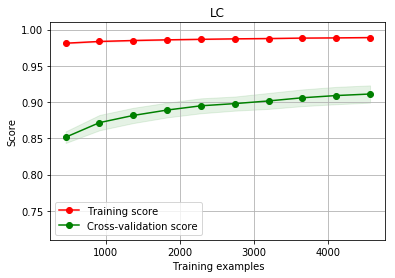

In [137]:
title = 'LC'
plot_learning_curve(predictor, title, X, Y, (0.71, 1.01), cv=7, n_jobs=-1, train_sizes=np.linspace(.1,1,10))

plt.show()

In [1197]:
predictor.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Анализ предиктов

In [169]:
predicted = predictor.predict(X_test)
predicted = pd.DataFrame(predicted, columns=['Ymin', 'Xmax', 'Ymax'])
predicted = pd.concat([predicted, y_test.reset_index()], axis=1)  # ДОбавляем true X,Y
predicted = predicted.merge(X_test[['Xmin', 'itemId']], left_on='index', right_index=True, how='outer')

predicted = predicted.merge(data[['Xmin_true']], left_on='index', right_index=True, how='inner')

predicted.shape
predicted.head()

Ymin    Xmax     Ymax  index  Ymin_true  Xmax_true  Ymax_true  Xmin  \
0   933.63  272.75  1068.83   1468        912        232       1038    66   
1   550.46  432.20   835.51    287        578        340        809   128   
2   964.58  246.00  1117.01   5259        981        235       1118    68   
3  1140.59  131.17  1183.89   4286       1147        124       1183   101   
4   733.24  652.54  1207.04   2057        665        811       1176   487   

   itemId  Xmin_true  
0   17366         90  
1    6090         47  
2   35081         49  
3   23104         54  
4    8713        236

In [168]:
# X[X['itemId']==17366]
# predicted[predicted['itemId']==17366]
# X_test[X_test['itemId']==17366]

In [170]:
res = predictByMinMax(predicted)

In [173]:
print(local_miou_score(res))

0.574406832396952


#### Вид данных

без полного ФИТа, смотрим на тестовую часть

In [139]:
predicted = predictor.predict(X_test)
predicted = pd.DataFrame(predicted, columns=['Ymin', 'Xmax', 'Ymax'])
predicted = pd.concat([predicted, y_test.reset_index()], axis=1)  # ДОбавляем true X,Y
predicted['X_test'] = 1
predicted.head()

Ymin    Xmax     Ymax  index  Ymin_true  Xmax_true  Ymax_true  X_test
0   933.63  272.75  1068.83   1468        912        232       1038       1
1   550.46  432.20   835.51    287        578        340        809       1
2   964.58  246.00  1117.01   5259        981        235       1118       1
3  1140.59  131.17  1183.89   4286       1147        124       1183       1
4   733.24  652.54  1207.04   2057        665        811       1176       1

In [125]:
predNtest = X_test[['Xmin', 'Xmax', 'Ymin', 'Ymax']]
# predNtest = pd.concat([predNtest, y_test.reset_index()], axis=1)  # ДОбавляем true X,Y
predNtest = predNtest.merge(y_test, left_index=True, right_index=True, how='outer')
predNtest['X_test'] = 1
print(predNtest.shape)
predNtest.head()


(1602, 9)


Xmin  Xmax  Ymin  Ymax  Xmin_true  Ymin_true  Xmax_true  Ymax_true  \
1468    66   211   935  1074         90        912        232       1038   
287    128   404   518   801         47        578        340        809   
5259    68   217   992  1162         49        981        235       1118   
4286   101   131  1146  1179         54       1147        124       1183   
2057   487   690   827  1071        236        665        811       1176   

      X_test  
1468       1  
287        1  
5259       1  
4286       1  
2057       1

In [126]:
predNtest = pd.concat([predicted, predNtest])
predNtest.drop('index', inplace=True, axis=1)
print(predNtest.shape)
print(predicted.shape)
predNtest.head()

(3204, 9)
(1602, 10)


/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


X_test    Xmax  Xmax_true    Xmin  Xmin_true     Ymax  Ymax_true     Ymin  \
0       2  268.80        232   90.91         90  1070.20       1038   931.47   
1       2  451.52        340   61.02         47   855.83        809   551.30   
2       2  243.14        235   54.99         49  1109.91       1118   962.66   
3       2  128.29        124   55.46         54  1184.72       1183  1144.20   
4       2  650.08        811  134.88        236  1218.59       1176   715.21   

   Ymin_true  
0        912  
1        578  
2        981  
3       1147  
4        665

In [127]:
predNtest[predNtest['X_test']==1]

X_test   Xmax  Xmax_true   Xmin  Xmin_true    Ymax  Ymax_true    Ymin  \
1468       1  211.0        232   66.0         90  1074.0       1038   935.0   
287        1  404.0        340  128.0         47   801.0        809   518.0   
5259       1  217.0        235   68.0         49  1162.0       1118   992.0   
4286       1  131.0        124  101.0         54  1179.0       1183  1146.0   
2057       1  690.0        811  487.0        236  1071.0       1176   827.0   
1463       1  197.0        232  107.0         90  1062.0       1038   954.0   
3656       1  975.0        993   28.0        342  1302.0       1136   589.0   
3276       1  569.0        721   91.0         42  1368.0       1557  1009.0   
1805       1  649.0        653  166.0        125   826.0        876   536.0   
3361       1  608.0        622   94.0        233   950.0        920   603.0   
3764       1  420.0        433   72.0         26   858.0        847   570.0   
4525       1  762.0        745   25.0        250   724.0        644   173.0   
188        1  315.0        325   73.0         44   992.0       1004   847.0   
2725       1  152.0        139   64.0         62  1108.0       1082  1035.0   
1257       1  341.0        388  148.0         35   926.0        997   686.0   
4005       1  493.0        355   46.0        139  1534.0       1555  1237.0   
250        1  322.0        282   57.0         51  1008.0       1132   885.0   
3554       1   64.0         64   46.0         42   893.0        898   885.0   
1945       1  697.0        740  308.0         22   917.0        899   527.0   
2305       1   58.0         59   47.0         47   845.0        842   832.0   
1417       1  106.0        128   37.0         51   698.0        699   637.0   
119        1  378.0        379  159.0         95  1202.0       1210  1087.0   
3204       1  390.0        321   29.0        147   473.0        479   256.0   
1820       1  128.0        142   90.0         54   895.0        884   848.0   
1591       1  421.0        507  216.0         91   829.0        833   648.0   
1574       1  522.0        589   34.0        123  1121.0       1101   683.0   
3517       1  246.0        249   71.0         92   741.0        730   567.0   
1207       1  168.0        256  100.0         16   469.0        539   397.0   
3778       1  322.0        371   57.0         49   483.0        562   294.0   
5273       1  133.0        103   51.0         62   849.0        839   791.0   
...      ...    ...        ...    ...        ...     ...        ...     ...   
4129       1  679.0        665  291.0         54   977.0       1039   615.0   
1413       1  250.0        247   34.0        114   733.0        693   573.0   
168        1  516.0        565   53.0        215   850.0        939   657.0   
2793       1  426.0        598   73.0         23   847.0        894   606.0   
299        1  854.0        884  105.0         22  1295.0       1050   724.0   
4283       1  130.0        124   96.0         54  1183.0       1183  1155.0   
1651       1  411.0        584  135.0          8   465.0        700   235.0   
1582       1  922.0       1029  124.0         24   941.0       1226   477.0   
4335       1  151.0        215   30.0         67   628.0        630   516.0   
5176       1  309.0        286   50.0         28   830.0        829   634.0   
1147       1  581.0        613   44.0          9   693.0        699   469.0   
3900       1  802.0        768  297.0        283   552.0        622   146.0   
2752       1  424.0        334  145.0         78  1014.0       1025   808.0   
3439       1  652.0        663  305.0        136  1279.0       1313   848.0   
1178       1  385.0        388   62.0         30   831.0        870   633.0   
1238       1  729.0        927  346.0        345   901.0        834   504.0   
1247       1  403.0        616  318.0        165  1132.0       1211   952.0   
3784       1  854.0        831  157.0         36  1352.0       1573   997.0   
1044       1  704.0        748  216.0          8   692.0

/home/ivan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ivan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ivan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ivan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


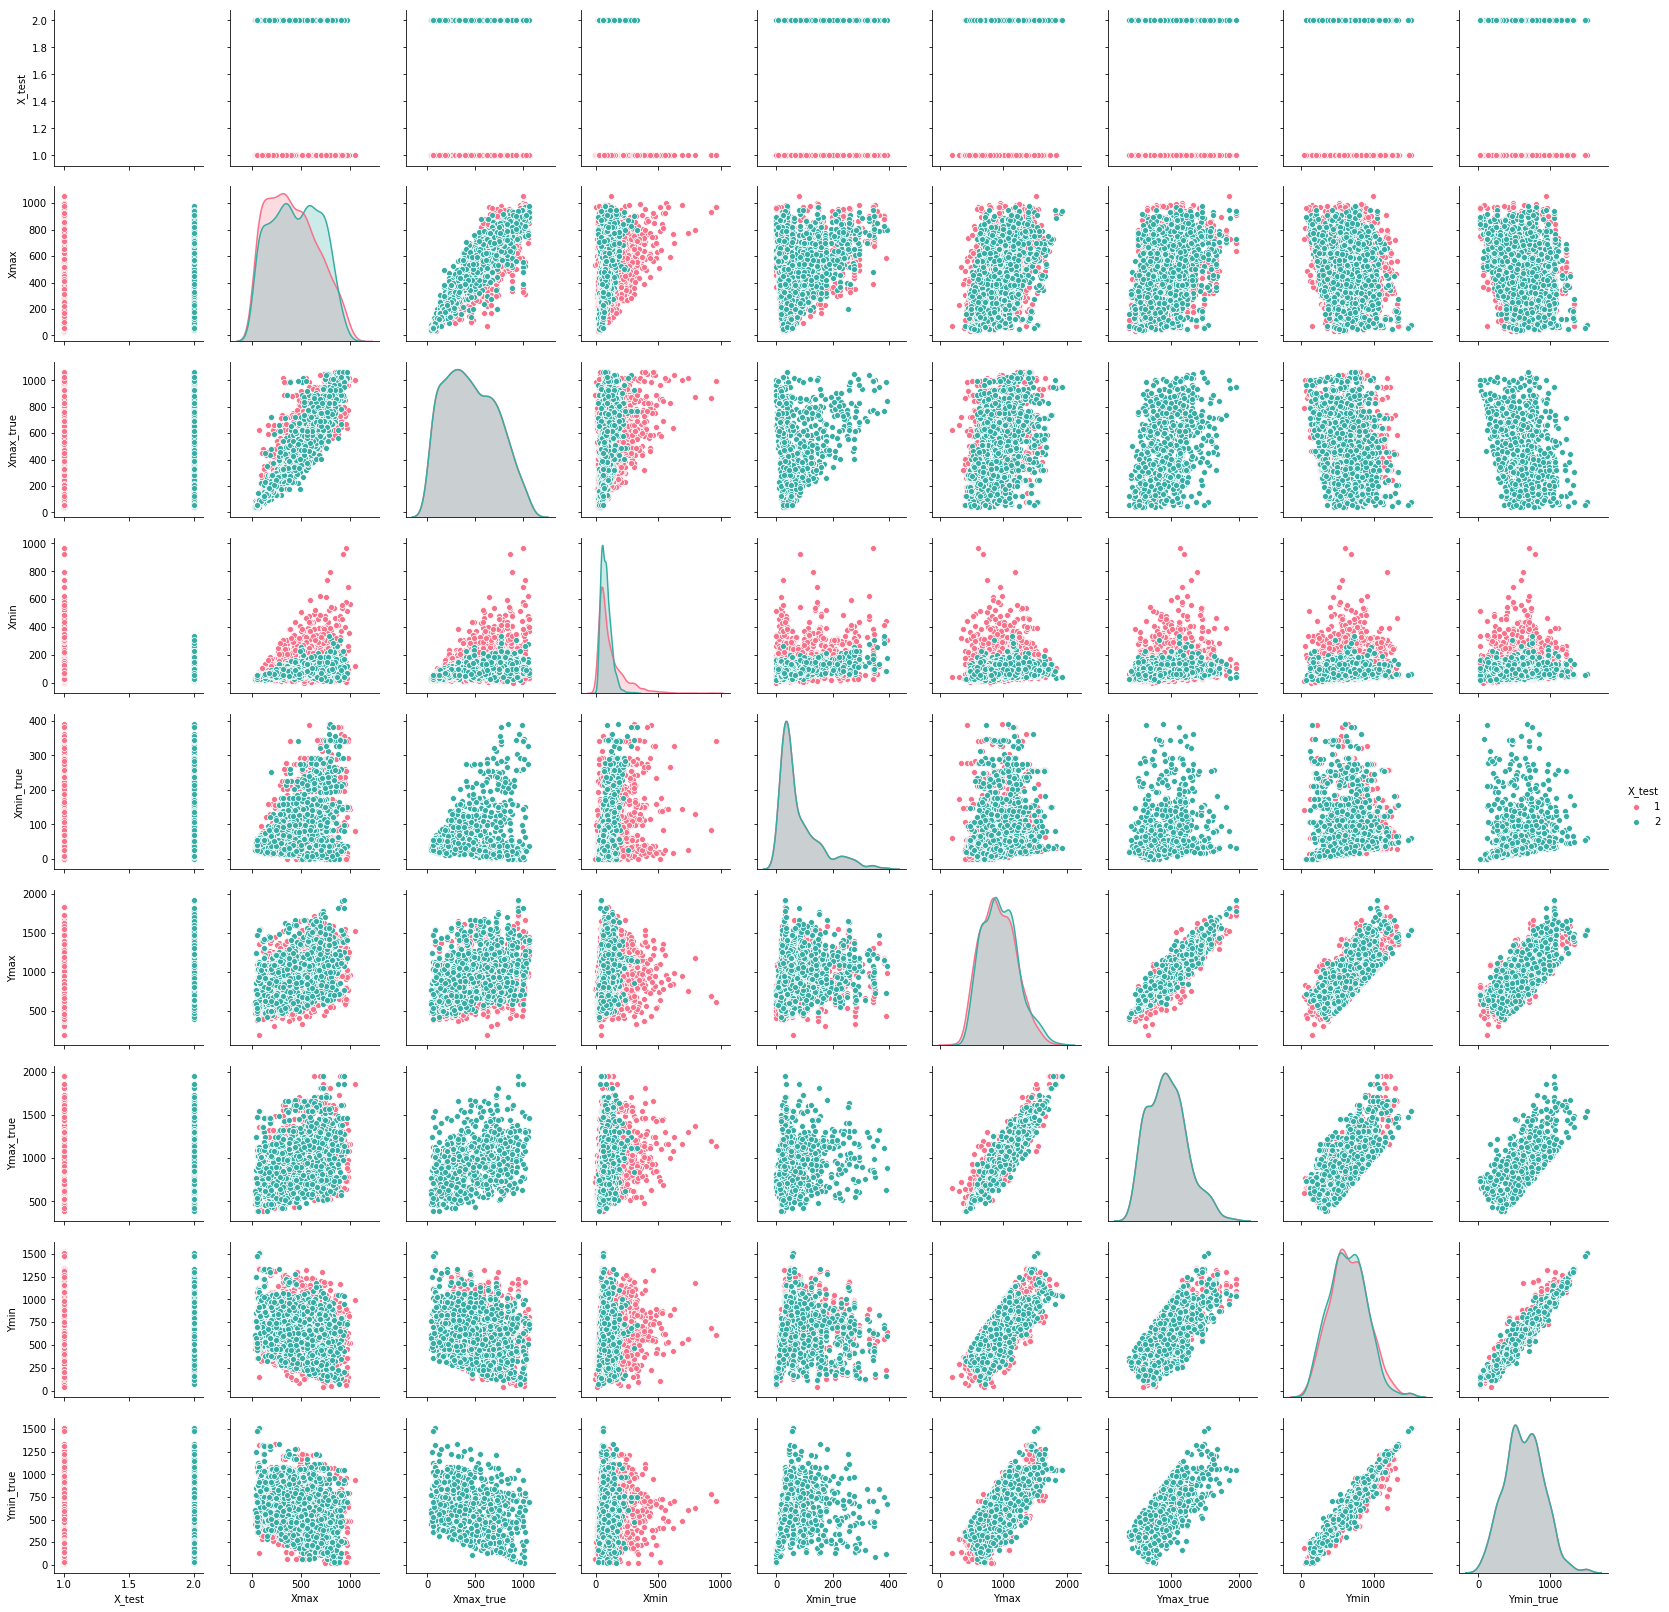

In [128]:
sns.pairplot(predNtest, hue="X_test", palette="husl")

###  Тестовые данные

In [1198]:
test_votes = init_test_data()
print(test_votes.columns)
print(test_votes.shape)
test_votes.head()

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], dtype='object')
(3615, 6)


userId  itemId  Xmin  Ymin  Xmax  Ymax
0    1581   34804    86   640   242   743
1    1351   34804    85   655   273   766
2     161   34804    85   648   268   748
3     313    5704    32   618   647  1268
4    1097    5704    25   620   602  1242

In [1199]:
test_votes = init_test_data()
print(test_votes.columns)

test_data = test_votes.merge(right=data[['userId', \
                'mean_user_iou', 'sum_user_iou', 'median_user_iou']], how='left', on='userId')

test_data = data_add_area(test_data)

test_data.drop_duplicates(inplace=True)
test_data.reset_index(inplace=True, drop=True);

print(test_data.columns)

Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], dtype='object')
Index(['userId', 'itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'mean_user_iou',
       'sum_user_iou', 'median_user_iou', 'area'],
      dtype='object')


In [1200]:
# NaN-ы  заполняем медианными значениями
# 
test_data['sum_user_iou'].fillna(value=test_data['sum_user_iou'].median(), inplace=True)
test_data['mean_user_iou'].fillna(value=test_data['mean_user_iou'].median(), inplace=True)
test_data['median_user_iou'].fillna(value=test_data['median_user_iou'].median(), inplace=True)


Проверяем структуру

In [1188]:
print(test_data.shape)
print(sum(pd.Series(test_data['mean_user_iou'].notna())))
test_data.head(20)

(3615, 10)
3615


userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou  \
0     1581   34804    86   640   242   743       0.475942      1.903770   
1     1351   34804    85   655   273   766       0.475073      5.225801   
2      161   34804    85   648   268   748       0.495931     16.861646   
3      313    5704    32   618   647  1268       0.529712      2.648560   
4     1097    5704    25   620   602  1242       0.537014      9.666254   
5     1525    5704   118   690   583  1191       0.551020      1.102039   
6      957   32082    50   437   259   575       0.465749     18.164228   
7      947   32082    42   414   252   583       0.463139      8.799637   
8      237   32082    63   424   250   569       0.488976      1.466929   
9      191   32082    59   483   262   584       0.318399      8.596778   
10     465   32082    41   426   256   588       0.336250      1.681248   
11     128   32082    40   433   259   577       0.533770      8.540315   
12     307   25757   287   286   993   781       0.471088      2.425149   
13    1508   25757   389   389   803   715       0.378287     29.884709   
14    1454   25757   382   322   916   789       0.484341      3.390385   
15     161   18505    33   582    92   640       0.495931     16.861646   
16     374   18505    35   584    93   639       0.328688      0.986063   
17    1304   18505    37   599    67   627       0.362476      2.899808   
18    1033   18505    33   583    91   639       0.430193      1.290578   
19     312   18505    34   583    91   639       0.471088      2.425149   

    median_user_iou    area  
0          0.493215   16068  
1          0.537190   20868  
2          0.484469   18300  
3          0.442870  399750  
4          0.528277  358894  
5          0.551020  232965  
6          0.465030   28842  
7          0.467723   35490  
8          0.417994   27115  
9          0.322420   20503  
10         0.375470   34830  
11         0.496970   31536  
12         0.477304  349470  
13         0.381162  134964  
14         0.474203  249378  
15         0.484469    3422  
16         0.419053    3190  
17         0.394945     840  
18         0.507234    3248  
19         0.477304    3192

In [1201]:
test_structure(test_data)

(630,)
(630,)
All good


Делаем прогноз

In [1202]:
predicted = predictor.predict(test_data)

predicted = pd.DataFrame(predicted, columns=['Xmin','Ymin', 'Xmax', 'Ymax'])
predicted['itemId'] = test_data['itemId'].values
predicted

Xmin     Ymin    Xmax     Ymax  itemId
0      42.21   642.29  293.39   800.15   34804
1      48.16   638.06  282.27   809.82   34804
2      44.39   635.27  294.15   805.85   34804
3      80.96   649.42  661.10  1134.61    5704
4      83.92   643.30  661.39  1146.51    5704
5     104.47   689.81  675.98  1132.08    5704
6      51.54   390.98  314.22   605.56   32082
7      49.73   375.22  321.13   590.12   32082
8      56.56   394.17  301.11   593.34   32082
9      46.54   410.58  318.58   619.31   32082
10     59.69   388.69  338.26   604.68   32082
11     55.96   393.98  313.70   600.06   32082
12     88.23   270.86  815.49   835.14   25757
13    119.26   359.00  798.94   816.15   25757
14     88.39   282.37  799.81   848.08   25757
15     35.91   593.09   92.49   640.60   18505
16     36.28   593.74   99.31   649.05   18505
17     38.23   598.51   74.12   628.02   18505
18     36.41   594.27   95.43   645.14   18505
19     35.78   594.41   95.36   645.34   18505
20     36.11   595.23   94.51   644.51   18505
21    100.83   731.84  392.23   986.68    7318
22     98.38   716.64  382.11   967.67    7318
23     88.86   708.55  427.52   996.53    7318
24    118.45   304.14  676.54   707.59    4673
25     91.20   280.41  611.88   690.01    4673
26     82.47   257.71  721.12   760.05    4673
27     79.52   256.15  599.59   652.04    4673
28     92.89   299.61  540.84   649.38    4673
29    128.17   651.20  621.22  1116.01   21769
...      ...      ...     ...      ...     ...
3585   56.00  1304.40  137.47  1396.24   29284
3586   60.57   403.91  408.52   686.00    5747
3587   96.37   404.03  459.64   712.41    5747
3588   63.51   419.43  446.20   683.49    5747
3589   98.29   506.15  390.15   748.79    5747
3590   69.30   392.56  458.27   680.94    5747
3591   93.46   437.62  433.77   704.04    5747
3592   97.64   408.39  453.46   712.96    5747
3593   99.20   448.75  712.16   905.19   30935
3594  136.79   507.25  617.81   895.54   30935
3595  176.14   506.99  576.90   849.27   30935
3596  142.80   491.81  605.89   876.81   30935
3597   73.88   473.47  713.42   939.74   30935
3598   68.43   820.75  203.06   928.95     432
3599   81.48   852.89  465.24  1205.80     432
3600   74.53   848.87  477.19  1213.84     432
3601   47.54   631.26  132.34   691.99   32282
3602   46.23   615.04  131.44   675.69   32282
3603   42.12   622.80  110.31   673.38   32282
3604   87.07   817.79  521.85  1189.47   13921
3605   92.89   787.50  530.73  1126.99   13921
3606   89.60   758.47  581.26  1154.25   13921
3607   27.14   381.31  132.65   453.73    8358
3608   27.46   382.78  150.49   465.71    8358
3609   27.46   382.78  150.49   465.71    8358
3610   29.22   382.63  159.82   469.71    8358
3611   28.36   382.27  158.42   468.42    8358
3612   78.70   393.07  891.36  1021.10   33300
3613  106.41   453.18  889.49  1083.58   33300
3614   89.61   452.00  912.61  1069.83   33300

[3615 rows x 5 columns]

In [1141]:
predicted.groupby("itemId")[['Xmin']].count()

Xmin
itemId      
18         2
19         3
33         3
62         7
114        3
146        8
156        3
163        6
164        3
179        3
186        7
215        3
225        8
227        5
247        8
275        7
311       10
399        6
421        6
432        3
442        3
459        3
492        3
507        9
631        3
707        6
723        7
1003       7
1065      10
1136       7
...      ...
34122      3
34143      7
34284      9
34340      3
34455      3
34465      3
34471      5
34483      6
34652      3
34655      8
34796      8
34804      3
34958      8
35020      3
35021      3
35110      6
35118      6
35128      3
35227      3
35307      3
35512      5
35514      7
35544      5
35660      8
35682      8
35685     10
35695      5
35966      3
35973      3
35978      7

[630 rows x 1 columns]

In [1111]:
predicted[predicted['itemId'] == 18]

Xmin        Ymin        Xmax         Ymax  itemId
1230  131.287118  718.071490  674.404549  1169.371187      18
1231  147.568260  654.666349  769.550530  1175.019042      18

In [1102]:
test_data[test_data['itemId'] == 18]

userId  itemId  Xmin  Ymin  Xmax  Ymax  mean_user_iou  sum_user_iou  \
1230     903      18   126   774   694  1010       0.482934     11.107477   
1231    1723      18   144   634   764  1132       0.413349      2.480096   

      median_user_iou    area  
1230         0.489660  134048  
1231         0.456958  308760

In [1109]:
test_data.groupby("itemId")[['userId']].count()

userId
itemId        
18           2
19           3
33           3
62           7
114          3
146          8
156          3
163          6
164          3
179          3
186          7
215          3
225          8
227          5
247          8
275          7
311         10
399          6
421          6
432          3
442          3
459          3
492          3
507          9
631          3
707          6
723          7
1003         7
1065        10
1136         7
...        ...
34122        3
34143        7
34284        9
34340        3
34455        3
34465        3
34471        5
34483        6
34652        3
34655        8
34796        8
34804        3
34958        8
35020        3
35021        3
35110        6
35118        6
35128        3
35227        3
35307        3
35512        5
35514        7
35544        5
35660        8
35682        8
35685       10
35695        5
35966        3
35973        3
35978        7

[630 rows x 1 columns]

Делаем МинМин-МаксМакс

In [1203]:
res = predict(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId  Xmin  Ymin  Xmax  Ymax
0      18   126   634   764  1132
1      19    27   559   119   729
2      33    21   380   414   652
3      62    35   824   639  1262
4     114    41   570   216   780
5     146    17   211   643  1118
6     156    74   802   160   887
7     163    21   317   213   465
8     164     4   146   401   681
9     179   116   490   330   733

In [1204]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

## ММММ по фильтрованными данным

In [12]:
data = init_data()
data = data_add_iou(data)
data = data_add_area(data)

data = data_drop_nullarea(data)
data = data_drop_nullareatrue(data)

# # расчёт заново
data = data_add_iou(data)
data = data_add_area(data)

data = data_add_xy_err(data)

Xmin_med_err = data.groupby('Xmin')['Xmin_err'].quantile(.58) 
Xmin_med_err = pd.DataFrame(Xmin_med_err);  Xmin_med_err.columns = ['Xmin_med_err']
data = data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
data.Xmin += data.Xmin_med_err

Ymin_med_err = data.groupby('Ymin')['Ymin_err'].quantile(.7294736842105263)
Ymin_med_err = pd.DataFrame(Ymin_med_err);  Ymin_med_err.columns = ['Ymin_med_err']
data = data.merge(right=Ymin_med_err, how='inner', left_on='Ymin', right_index=True)
data.Ymin += data.Ymin_med_err

Xmax_med_err = data.groupby('Xmax')['Xmax_err'].quantile(0)
Xmax_med_err = pd.DataFrame(Xmax_med_err);  Xmax_med_err.columns = ['Xmax_med_err']
data = data.merge(right=Xmax_med_err, how='inner', left_on='Xmax', right_index=True)
data.Xmax += data.Xmax_med_err

Ymax_med_err = data.groupby('Ymax')['Ymax_err'].quantile(.3126315789473684)
Ymax_med_err = pd.DataFrame(Ymax_med_err);  Ymax_med_err.columns = ['Ymax_med_err']
data = data.merge(right=Ymax_med_err, how='inner', left_on='Ymax', right_index=True)
data.Ymax += data.Ymax_med_err


res = predictByMinMax(data)
print(local_miou_score(res))

0.6220683832050419


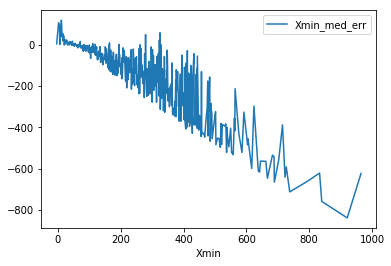

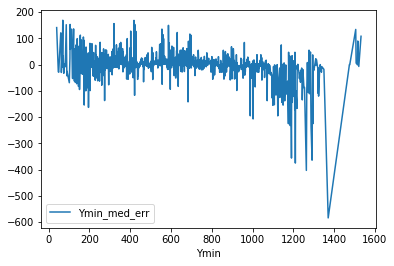

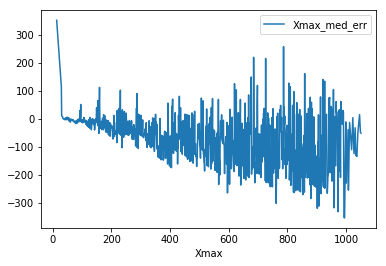

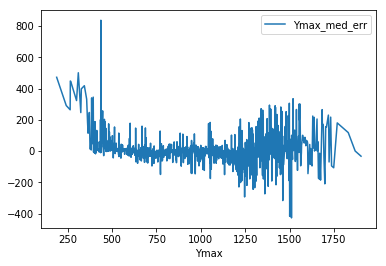

In [26]:
Xmin_med_err.plot()
Ymin_med_err.plot()
Xmax_med_err.plot()
Ymax_med_err.plot()

In [83]:
test_data = init_test_data()
test_data = data_add_area(test_data)

# # фильтрация
test_data = data_drop_nullarea(test_data)

# # расчёт заново
# test_data = data_add_area(test_data)

# # коррекция ХУ по ошибкам трейна

# test_data = apply_xy_correctorbyError(test_data)

test_data = test_data.merge(right=Xmin_med_err, how='inner', left_on='Xmin', right_index=True)
test_data.Xmin += test_data.Xmin_med_err

# test_data = test_data.merge(right=Ymin_med_err, how='inner', left_on='Ymin', right_index=True)
# # test_data = test_data.merge(right=Ymin_med_err, how='outer', left_on='Ymin', right_index=True)
# test_data.Ymin += test_data.Ymin_med_err

# test_data = test_data.merge(right=Xmax_med_err, how='inner', left_on='Xmax', right_index=True)
# test_data.Xmax += test_data.Xmax_med_err

# test_data = test_data.merge(right=Ymax_med_err, how='inner', left_on='Ymax', right_index=True)
# test_data.Ymax += test_data.Ymax_med_err



test_structure(test_data)

test_data.head()

Весь DataFrame: Должны быть равны
(3534, 8)  /  (3615, 6)
unique: Должны быть равны
(630,)  /  (630,)
All good


userId  itemId   Xmin  Ymin  Xmax  Ymax    area  Xmin_med_err
0       1581   34804  60.68   640   242   743   16068        -25.32
86      1742    1565  60.68   730   228   813   11786        -25.32
1071     952   34000  60.68   899   100   920     294        -25.32
1754    1652   21169  60.68   503   255   650   24843        -25.32
2019     379   19608  60.68   384   594   729  175260        -25.32

In [84]:
if test_data.index.has_duplicates:
    print(sum(test_data.index.duplicated()))

In [85]:
# test_data[-20:]
test_data[test_data.isna().values]

Empty DataFrame
Columns: [userId, itemId, Xmin, Ymin, Xmax, Ymax, area, Xmin_med_err]
Index: []

In [86]:
test_data[test_data['itemId'] == 4997]

userId  itemId    Xmin  Ymin  Xmax  Ymax   area  Xmin_med_err
2750     886    4997   53.00  1370   265  1493  27552         12.00
2752    1369    4997   49.16  1380   296  1494  24510        -31.84
2749     567    4997   62.00  1375   312  1478  24205        -15.00
2753     401    4997   82.36  1362   320  1538  41008         -4.64
2754     221    4997   43.00  1368   296  1501  34314          5.00
2751    1116    4997  112.80  1354   343  1508  33880        -10.20
2748     505    4997   31.28  1366   277  1502  13872       -143.72
2747     931    4997   57.72  1500   376  1502     70       -283.28

Делаем МинМин-МаксМакс

In [87]:
res = predictByMinMax(test_data)
print(res.shape)
res.head(10)

(630, 5)


itemId   Xmin  Ymin  Xmax  Ymax
0      18  53.10   634   764  1132
1      19  43.04   559   119   729
2      33  22.62   380   414   652
3      62  42.42   824   639  1262
4     114  53.00   570   216   780
5     146  34.48   211   643  1118
6     156  65.92   802   160   887
7     163  22.62   317   213   465
8     164   7.06   149   349   650
9     179  67.16   490   330   733

In [88]:
res.to_csv('submit.csv', columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax'], header=False, index=False)

del res

#  Разное

In [ ]:
TODO
 - возможно к нкоторым пользователям были специально сдвинуты координаты, а значит нужно их найти и их координаты сдвигать обратно
 - взвешенное голосование, с учетом mean_user_iou
 - plot.box данных - удалятьвыбросы
    
    # Удаляем из выборки потому что это скорее всего выбросы
# потому что там площадь выделения равно 0, как так?
# selected = data[data['itemId'] == 25135].index
# data.drop(selected, inplace=True)


**Гипотеза**. См. рис. ниже. У точек есть определённое смещение относительно оси. Зная статистику смещения, можно пробовать их смещать "интуитивно" : по среденему, медиане; для данного диапазона значений.

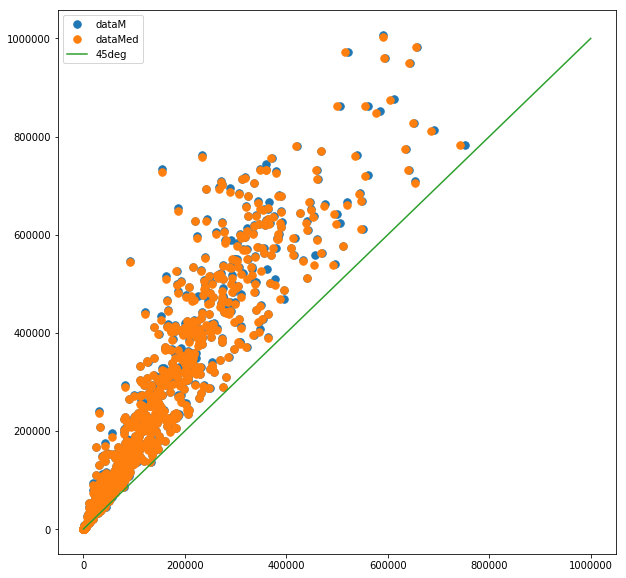

In [501]:
plt.figure(figsize=(10,10))
plt.plot(dataM['intesect'], dataM['union'], '.', label='dataM', markersize=15)
plt.plot(dataMed['intesect'], dataMed['union'], '.', label='dataMed', markersize=15)
plt.plot([0, 1000000], [0, 1000000], label='45deg')
plt.legend()

Мысль: с помощью способов выше я прогнозирую следующим образом: для конкретной пары Пользов-Картинка предсказываю Тру. Но это не совсем то, что нужно. По идее нужно вот такое: для группы Пользователей и одной Картинки предсказать ТРу.

Вопрос: как так организовать ДатаФрейм чтобы предиктить это? Тогда надо чтобы пользователи становились признаками -- ДатаФрейм будет разреженный. Объектами будут Картинки, целевыми признакми координаты ТРу.